<a href="https://colab.research.google.com/github/sanalpillai/Data-Cleaning-Feature-Selection-Modeling-and-Interpretability/blob/main/Data_Cleaning_Feature_Selection_Modeling_and_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
#!pip install --upgrade shap
#!pip install h2o
#!pip install xgboost
#!pip install eli5
#!pip install datasist
#!pip install fancyimpute

In [187]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [188]:
# Load the dataset
data_url = "https://raw.githubusercontent.com/sanalpillai/Data-Cleaning-Feature-Selection-Modeling-and-Interpretability/main/Dataset/cleaned_data_cirrhosis.csv"
data = pd.read_csv(data_url, index_col=0)

In [189]:
data.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [190]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [191]:
# Replace 'CL' with 'C' in the 'Status' column and 'S' with 'Y' in the 'Edema' column
data['Status'] = data['Status'].replace({'CL': 'C'})
data['Edema'] = data['Edema'].replace({'S': 'Y'})

In [192]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,Y,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,Y,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,C,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [193]:
import pandas as pd

# Count the number of NaNs in each column
nan_counts = data.isna().sum()

# Print the count of NaNs for each column
print(nan_counts)

# To only display columns that contain NaNs:
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Series([], dtype: int64)


In [194]:
data.corr()

<ipython-input-194-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
N_Days,1.000000,-0.125934,-0.403953,-0.099322,0.430829,-0.295723,0.152368,-0.187930,-0.111453,0.147495,-0.110685,-0.362013
Age,-0.125934,1.000000,0.002362,-0.145054,-0.182350,0.034519,-0.060708,-0.139050,0.002323,-0.145948,0.113916,0.187852
Bilirubin,-0.403953,0.002362,1.000000,0.336882,-0.314177,0.403761,0.104675,0.392112,0.370330,-0.013347,0.312007,0.200314
Cholesterol,-0.099322,-0.145054,0.336882,1.000000,-0.043022,0.145910,0.157995,0.347222,0.291750,0.158641,-0.027259,0.009930
Albumin,0.430829,-0.182350,-0.314177,-0.043022,1.000000,-0.209024,-0.070010,-0.180947,-0.068509,0.156384,-0.198405,-0.302190
Copper,-0.295723,0.034519,0.403761,0.145910,-0.209024,1.000000,0.207349,0.298923,0.292236,-0.040523,0.182494,0.232149
Alk_Phos,0.152368,-0.060708,0.104675,0.157995,-0.070010,0.207349,1.000000,0.122071,0.186250,0.133398,0.073408,0.037905
SGOT,-0.187930,-0.139050,0.392112,0.347222,-0.180947,0.298923,0.122071,1.000000,0.130853,-0.094383,0.094550,0.143568
Tryglicerides,-0.111453,0.002323,0.370330,0.291750,-0.068509,0.292236,0.186250,0.130853,1.000000,0.088806,0.014831,0.099879
Platelets,0.147495,-0.145948,-0.013347,0.158641,0.156384,-0.040523,0.133398,-0.094383,0.088806,1.000000,-0.154617,-0.240671


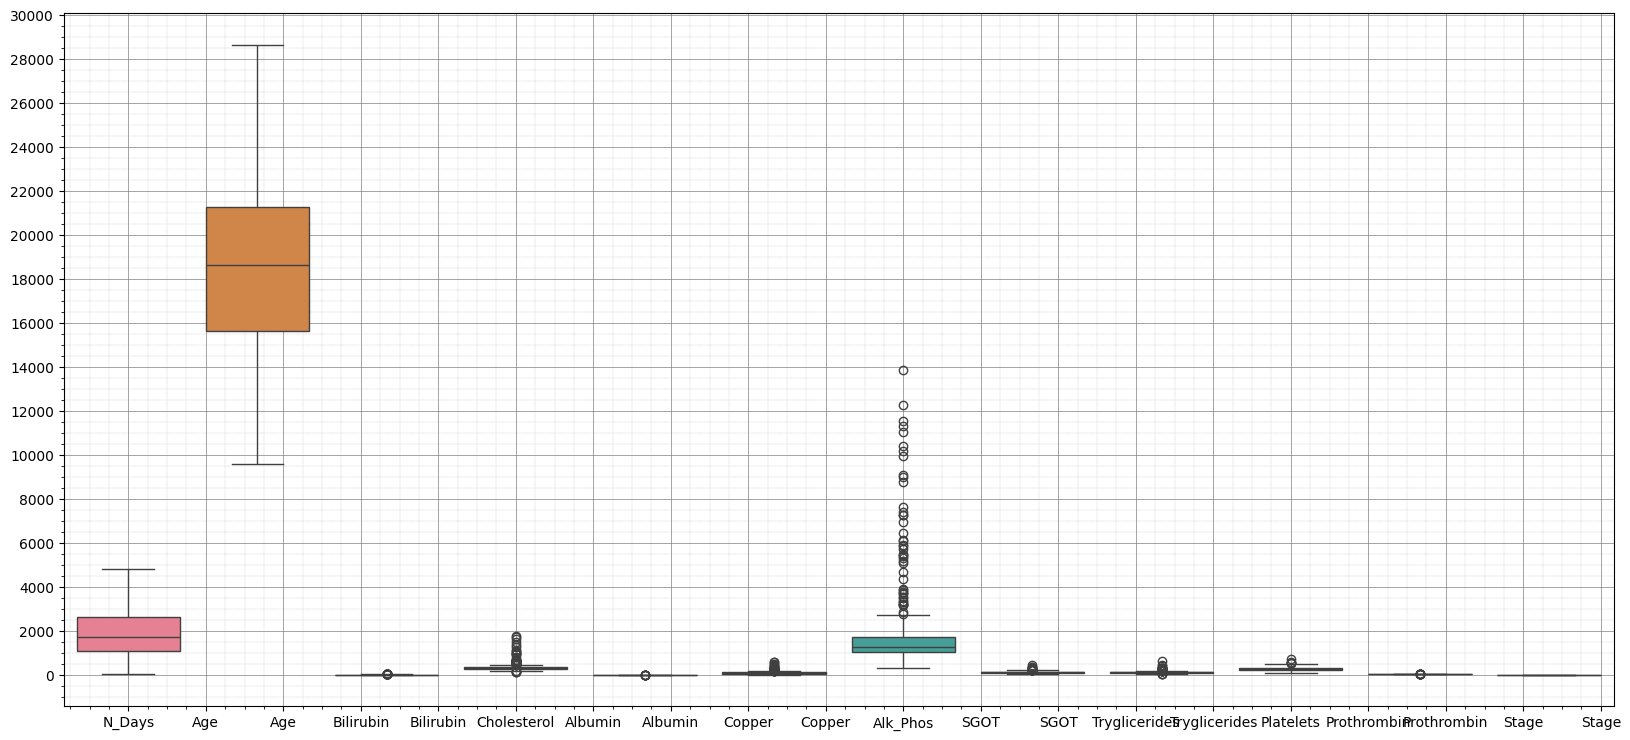

In [195]:
# Boxplot to visualize distributions and spot outliers
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

# Set major and minor ticks on both axes
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Set major x ticks to be more frequent
ax.yaxis.set_major_locator(plt.MaxNLocator(20))  # Set major y ticks to be more frequent

# Add gridlines and specify the grid for minor ticks as well
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.25)
plt.minorticks_on()  # Turn on minor ticks

plt.show()


In [196]:
#Making categories to 0 & 1
data["Status"] = data["Status"].map({"D": 0, "C": 1})
data["Drug"] = data["Drug"].map({"D-penicillamine": 0, "Placebo": 1})
data["Sex"] = data["Sex"].map({"F": 0, "M": 1})
data["Ascites"] = data["Ascites"].map({"N": 0, "Y": 1})
data["Hepatomegaly"] = data["Hepatomegaly"].map({"N": 0, "Y": 1})
data["Spiders"] = data["Spiders"].map({"N": 0, "Y": 1})
data["Edema"] = data["Edema"].map({"N": 0, "Y": 1})

# Viewing data
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,0,0,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,1,0,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,0,0,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,0,0,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,1,1,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [197]:
# Creating binary vaiables
data = pd.get_dummies(data)

# Normalizing the data in the columns

from sklearn import preprocessing

# Create variables to store scaled values as floats
a = data[["N_Days"]].values.astype(float)
b = data[["Age"]].values.astype(float)
c = data[["Bilirubin"]].values.astype(float)
d = data[["Cholesterol"]].values.astype(float)
e = data[["Albumin"]].values.astype(float)
f = data[["Copper"]].values.astype(float)
g = data[["Alk_Phos"]].values.astype(float)
h = data[["SGOT"]].values.astype(float)
i = data[["Tryglicerides"]].values.astype(float)
j = data[["Platelets"]].values.astype(float)
k = data[["Prothrombin"]].values.astype(float)
l = data[["Stage"]].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
a_scaled = min_max_scaler.fit_transform(a)
b_scaled = min_max_scaler.fit_transform(b)
c_scaled = min_max_scaler.fit_transform(c)
d_scaled = min_max_scaler.fit_transform(d)
e_scaled = min_max_scaler.fit_transform(e)
f_scaled = min_max_scaler.fit_transform(f)
g_scaled = min_max_scaler.fit_transform(g)
h_scaled = min_max_scaler.fit_transform(h)
i_scaled = min_max_scaler.fit_transform(i)
j_scaled = min_max_scaler.fit_transform(j)
k_scaled = min_max_scaler.fit_transform(k)
l_scaled = min_max_scaler.fit_transform(l)

# Run the normalizer on the dataframe
data[["N_Days"]] = pd.DataFrame(a_scaled)
data[["Age"]] = pd.DataFrame(b_scaled)
data[["Bilirubin"]] = pd.DataFrame(c_scaled)
data[["Cholesterol"]] = pd.DataFrame(d_scaled)
data[["Albumin"]] = pd.DataFrame(e_scaled)
data[["Copper"]] = pd.DataFrame(f_scaled)
data[["Alk_Phos"]] = pd.DataFrame(g_scaled)
data[["SGOT"]] = pd.DataFrame(h_scaled)
data[["Tryglicerides"]] = pd.DataFrame(i_scaled)
data[["Platelets"]] = pd.DataFrame(j_scaled)
data[["Prothrombin"]] = pd.DataFrame(k_scaled)
data[["Stage"]] = pd.DataFrame(l_scaled)

# Handling NaNs by filling them with the mean of each column
data = data.fillna(data.mean())

In [198]:
# pair plot to check the colinearity
# sns.pairplot(data)

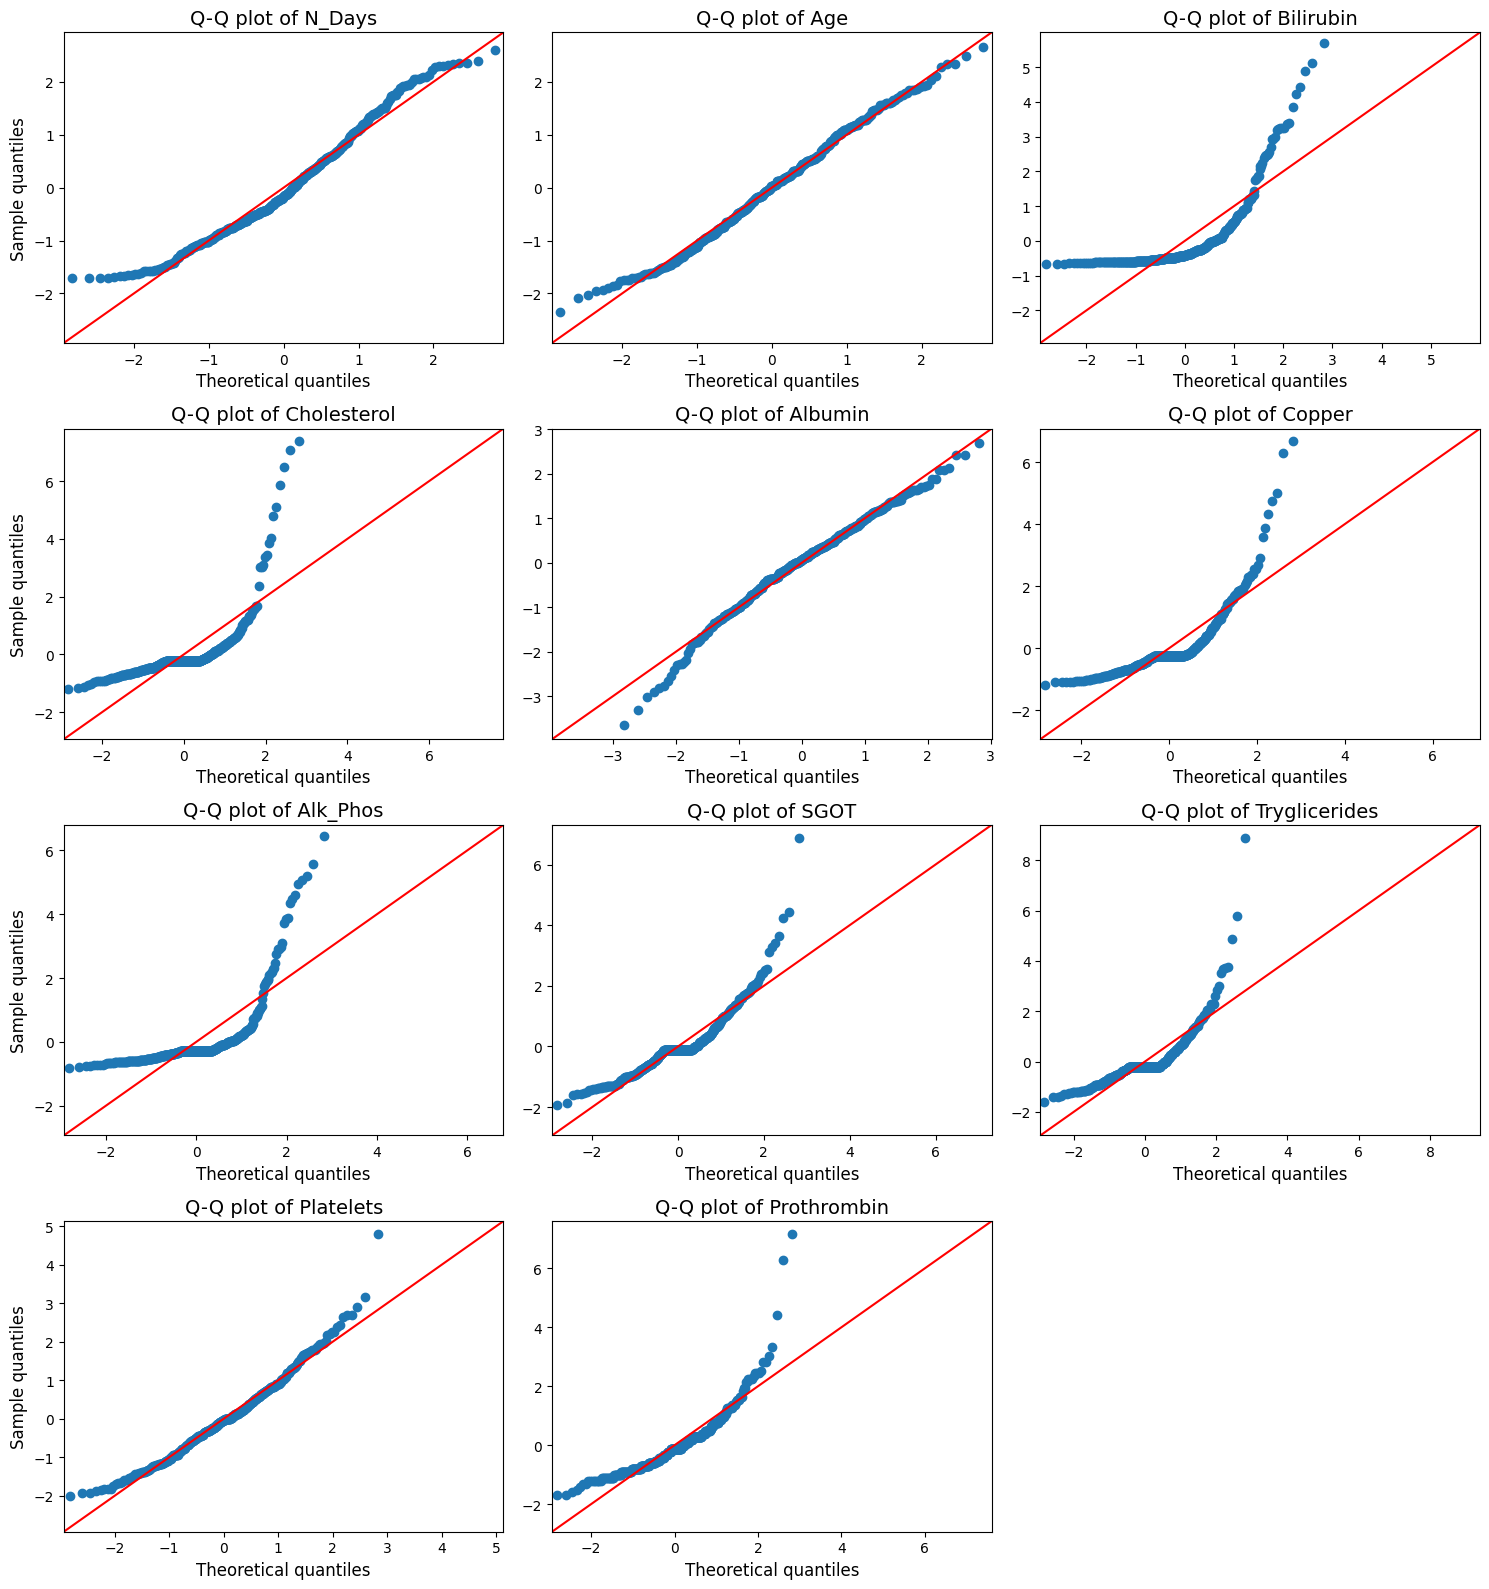

In [199]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

# List of independent numerical variables
numerical_vars = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin',
                  'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Determine the number of rows needed for the subplots
num_vars = len(numerical_vars)
rows = 4
cols = (num_vars + rows - 1) // rows  # This ensures that we have enough columns

# Set up the matplotlib figure, adjust the size as needed
plt.figure(figsize=(cols * 5, rows * 4))  # Adjust figure size as needed

# Generate Q-Q plots for each numerical variable
for i, var in enumerate(numerical_vars):
    plt.subplot(rows, cols, i+1)  # rows, cols, index of subplot
    qqplot(data[var], line='45', fit=True, ax=plt.gca())
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Theoretical quantiles', fontsize=12)
    plt.ylabel('Sample quantiles' if i % cols == 0 else '', fontsize=12)  # Only label y-axis for the first column
    plt.title(f'Q-Q plot of {var}', fontsize=14)

plt.tight_layout()
plt.show()


Class Distribution:
1    257
0    161
Name: Status, dtype: int64

Class Proportions:
1    0.614833
0    0.385167
Name: Status, dtype: float64


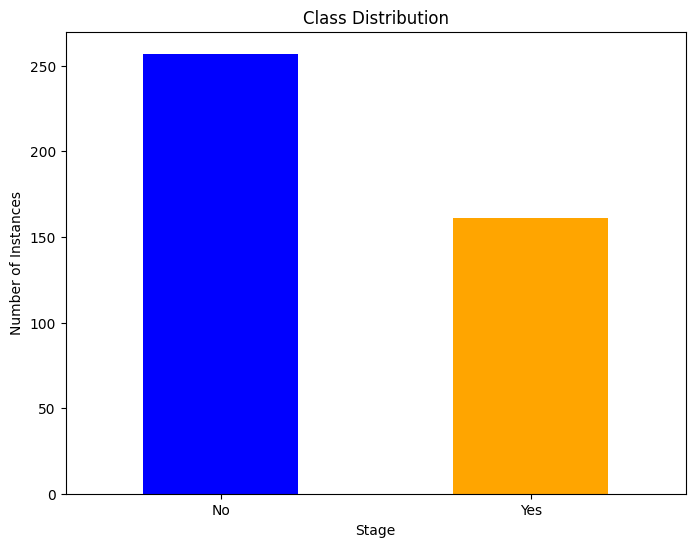

In [200]:
# Count the number of instances for each class
class_counts = data['Status'].value_counts()

# Calculate the proportion of each class label relative to the total number of instances
total_instances = len(data)
class_proportions = class_counts / total_instances

print("Class Distribution:")
print(class_counts)
print("\nClass Proportions:")
print(class_proportions)

# Visualize the class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Stage')
plt.ylabel('Number of Instances')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

Class Distribution after SMOTE:
1    176
0    176
Name: Status, dtype: int64

Class Proportions after SMOTE:
1    0.5
0    0.5
Name: Status, dtype: float64


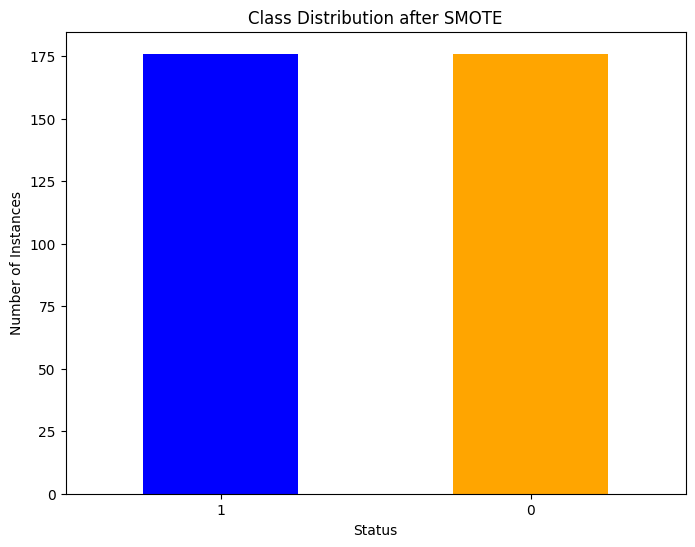

In [201]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it includes the columns of interest
# Replace 'feature_columns' with your actual list of feature column names
feature_columns = ['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
                   'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                   'Tryglicerides', 'Platelets', 'Prothrombin']  # example feature columns

# Separate input features and target variable
X = data[feature_columns]
y = data['Status']

# Split your data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize the SMOTE object
smote = SMOTE(random_state=1)

# Fit the SMOTE object to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Count the number of instances for each class after SMOTE
class_counts_smote = pd.Series(y_train_smote).value_counts()

# Calculate the proportion of each class label relative to the total number of instances after SMOTE
total_instances_smote = len(y_train_smote)
class_proportions_smote = class_counts_smote / total_instances_smote

print("Class Distribution after SMOTE:")
print(class_counts_smote)
print("\nClass Proportions after SMOTE:")
print(class_proportions_smote)

# Visualize the class distribution after SMOTE
plt.figure(figsize=(8, 6))
class_counts_smote.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution after SMOTE')
plt.xlabel('Status')
plt.ylabel('Number of Instances')
plt.xticks([0, 1], class_counts_smote.index, rotation=0)  # Assuming the class labels are 0 and 1
plt.show()

**Exploratory Data Analysis (EDA)**

In [202]:
# Viewing data
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,0.937947,0,0,0.578364,0,1,1,1,1,0.028881,0.109970,0.813433,0.085616,0.523509,0.202298,0.097345,0.241275,0.177778,0.666667
2,0.204249,1,0,0.839597,0,0,1,1,0,0.039711,0.033837,0.567164,0.352740,0.016724,0.161871,0.038938,0.135053,0.333333,1.000000
3,0.396298,0,0,0.545664,1,0,0,0,1,0.054152,0.074924,0.216418,0.102740,0.429723,0.079554,0.104425,0.183612,0.144444,1.000000
4,0.307741,0,0,0.226748,0,0,1,1,1,0.111913,0.096073,0.585821,0.238014,0.028143,0.201439,0.069027,0.112291,0.211111,0.666667
5,0.517880,1,1,0.766481,0,0,1,1,0,0.018051,0.077341,0.753731,0.078767,0.048256,0.154676,0.053097,0.295940,0.222222,0.666667


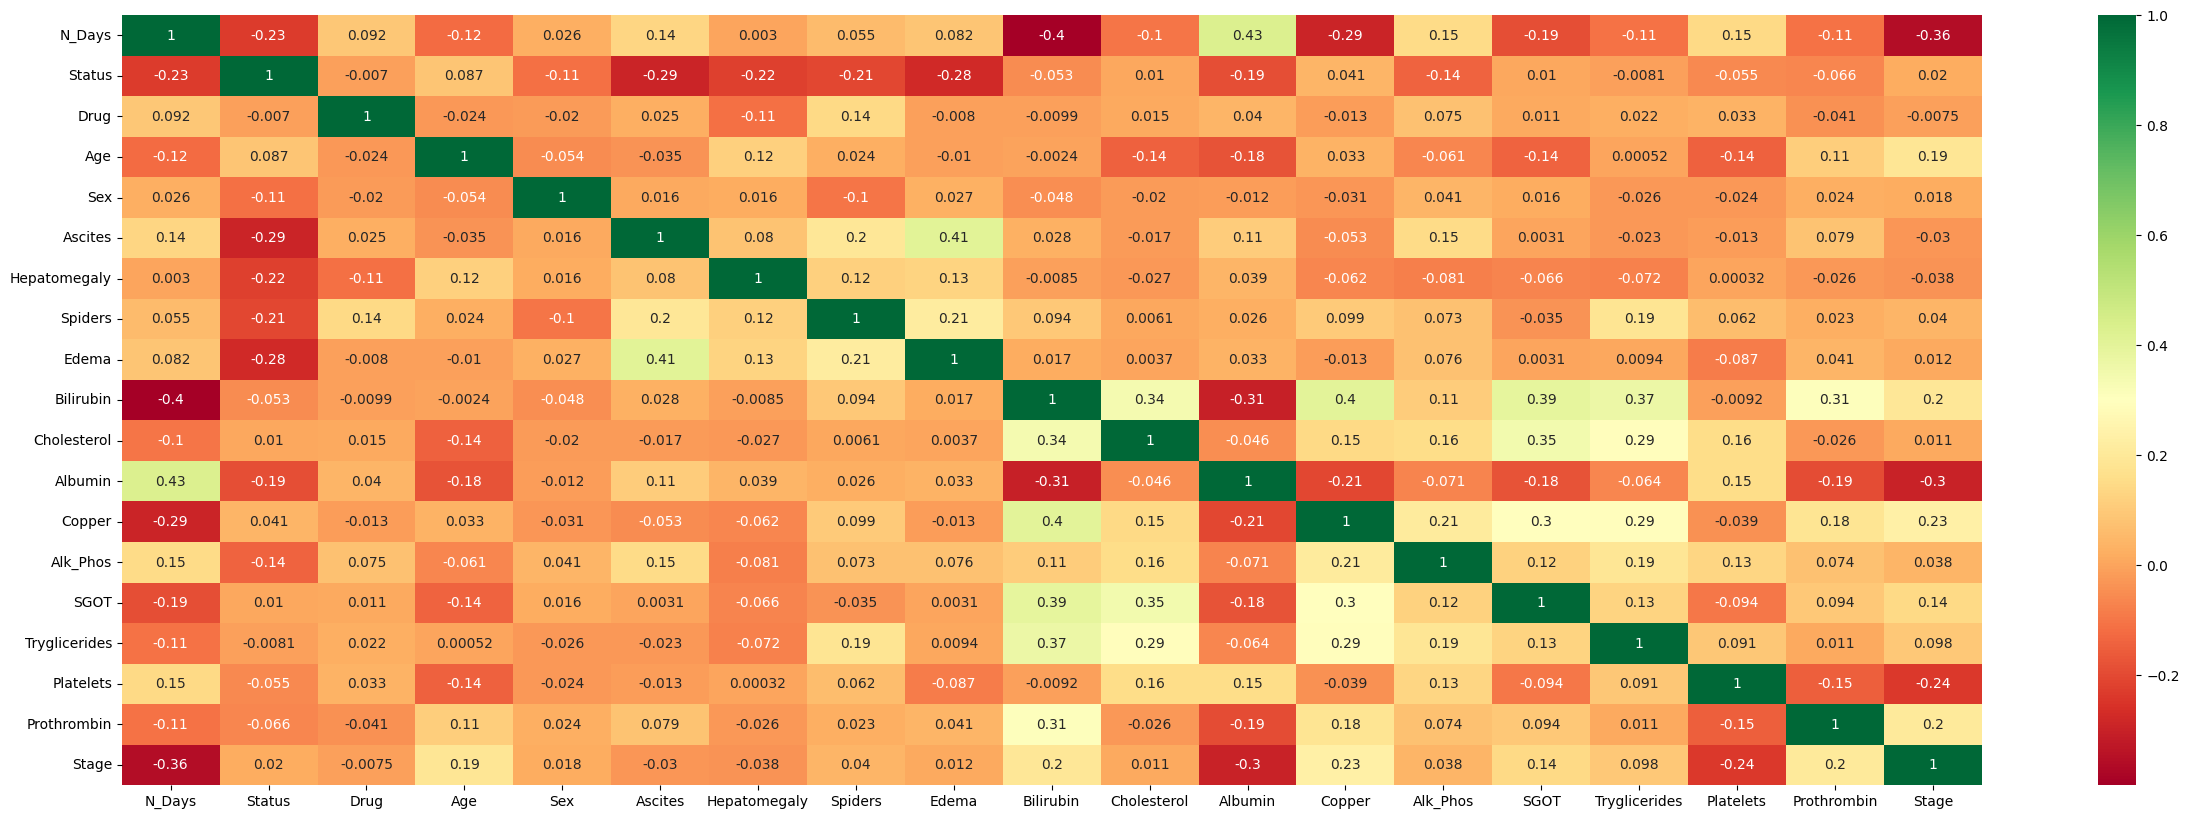

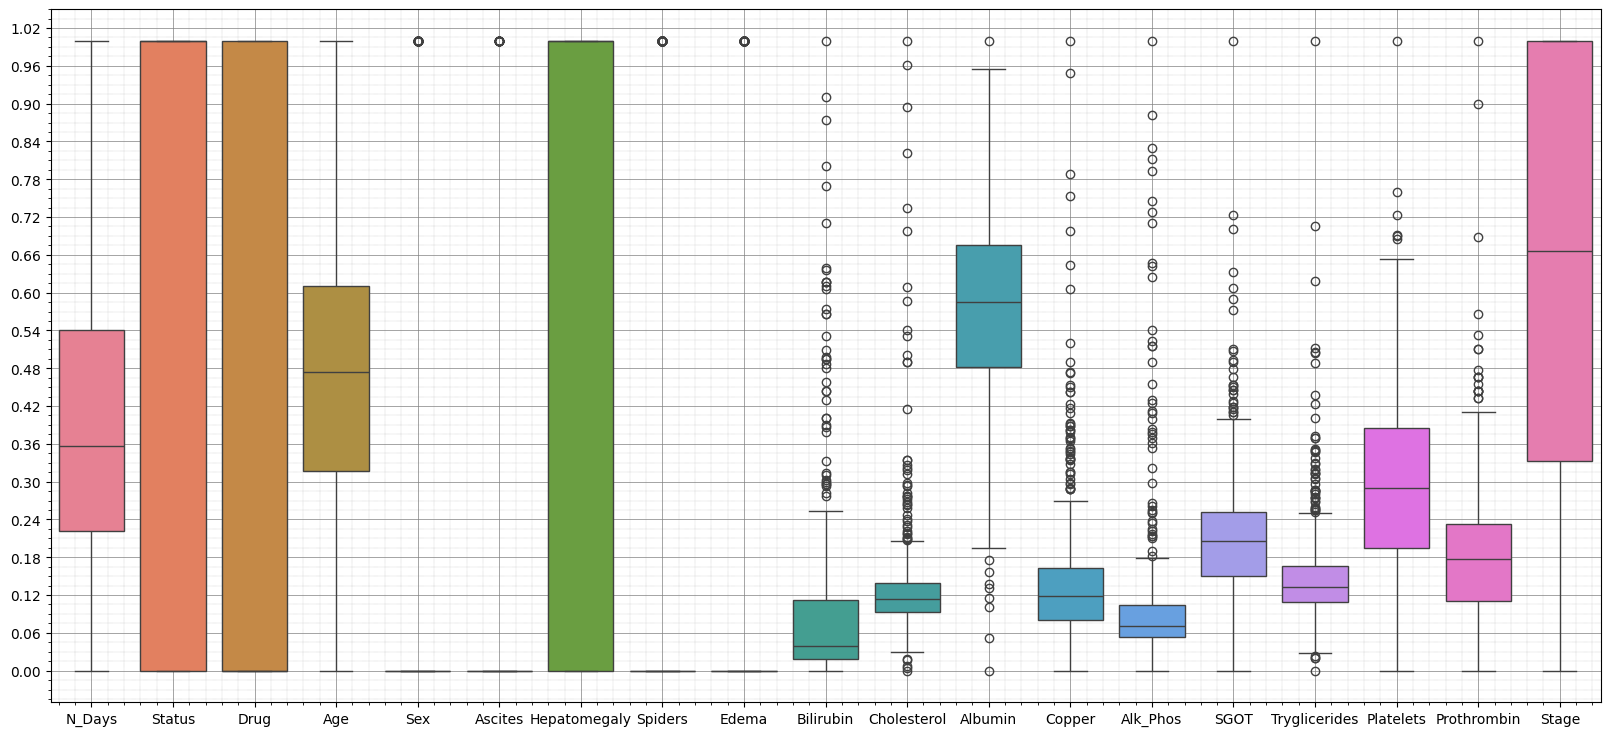

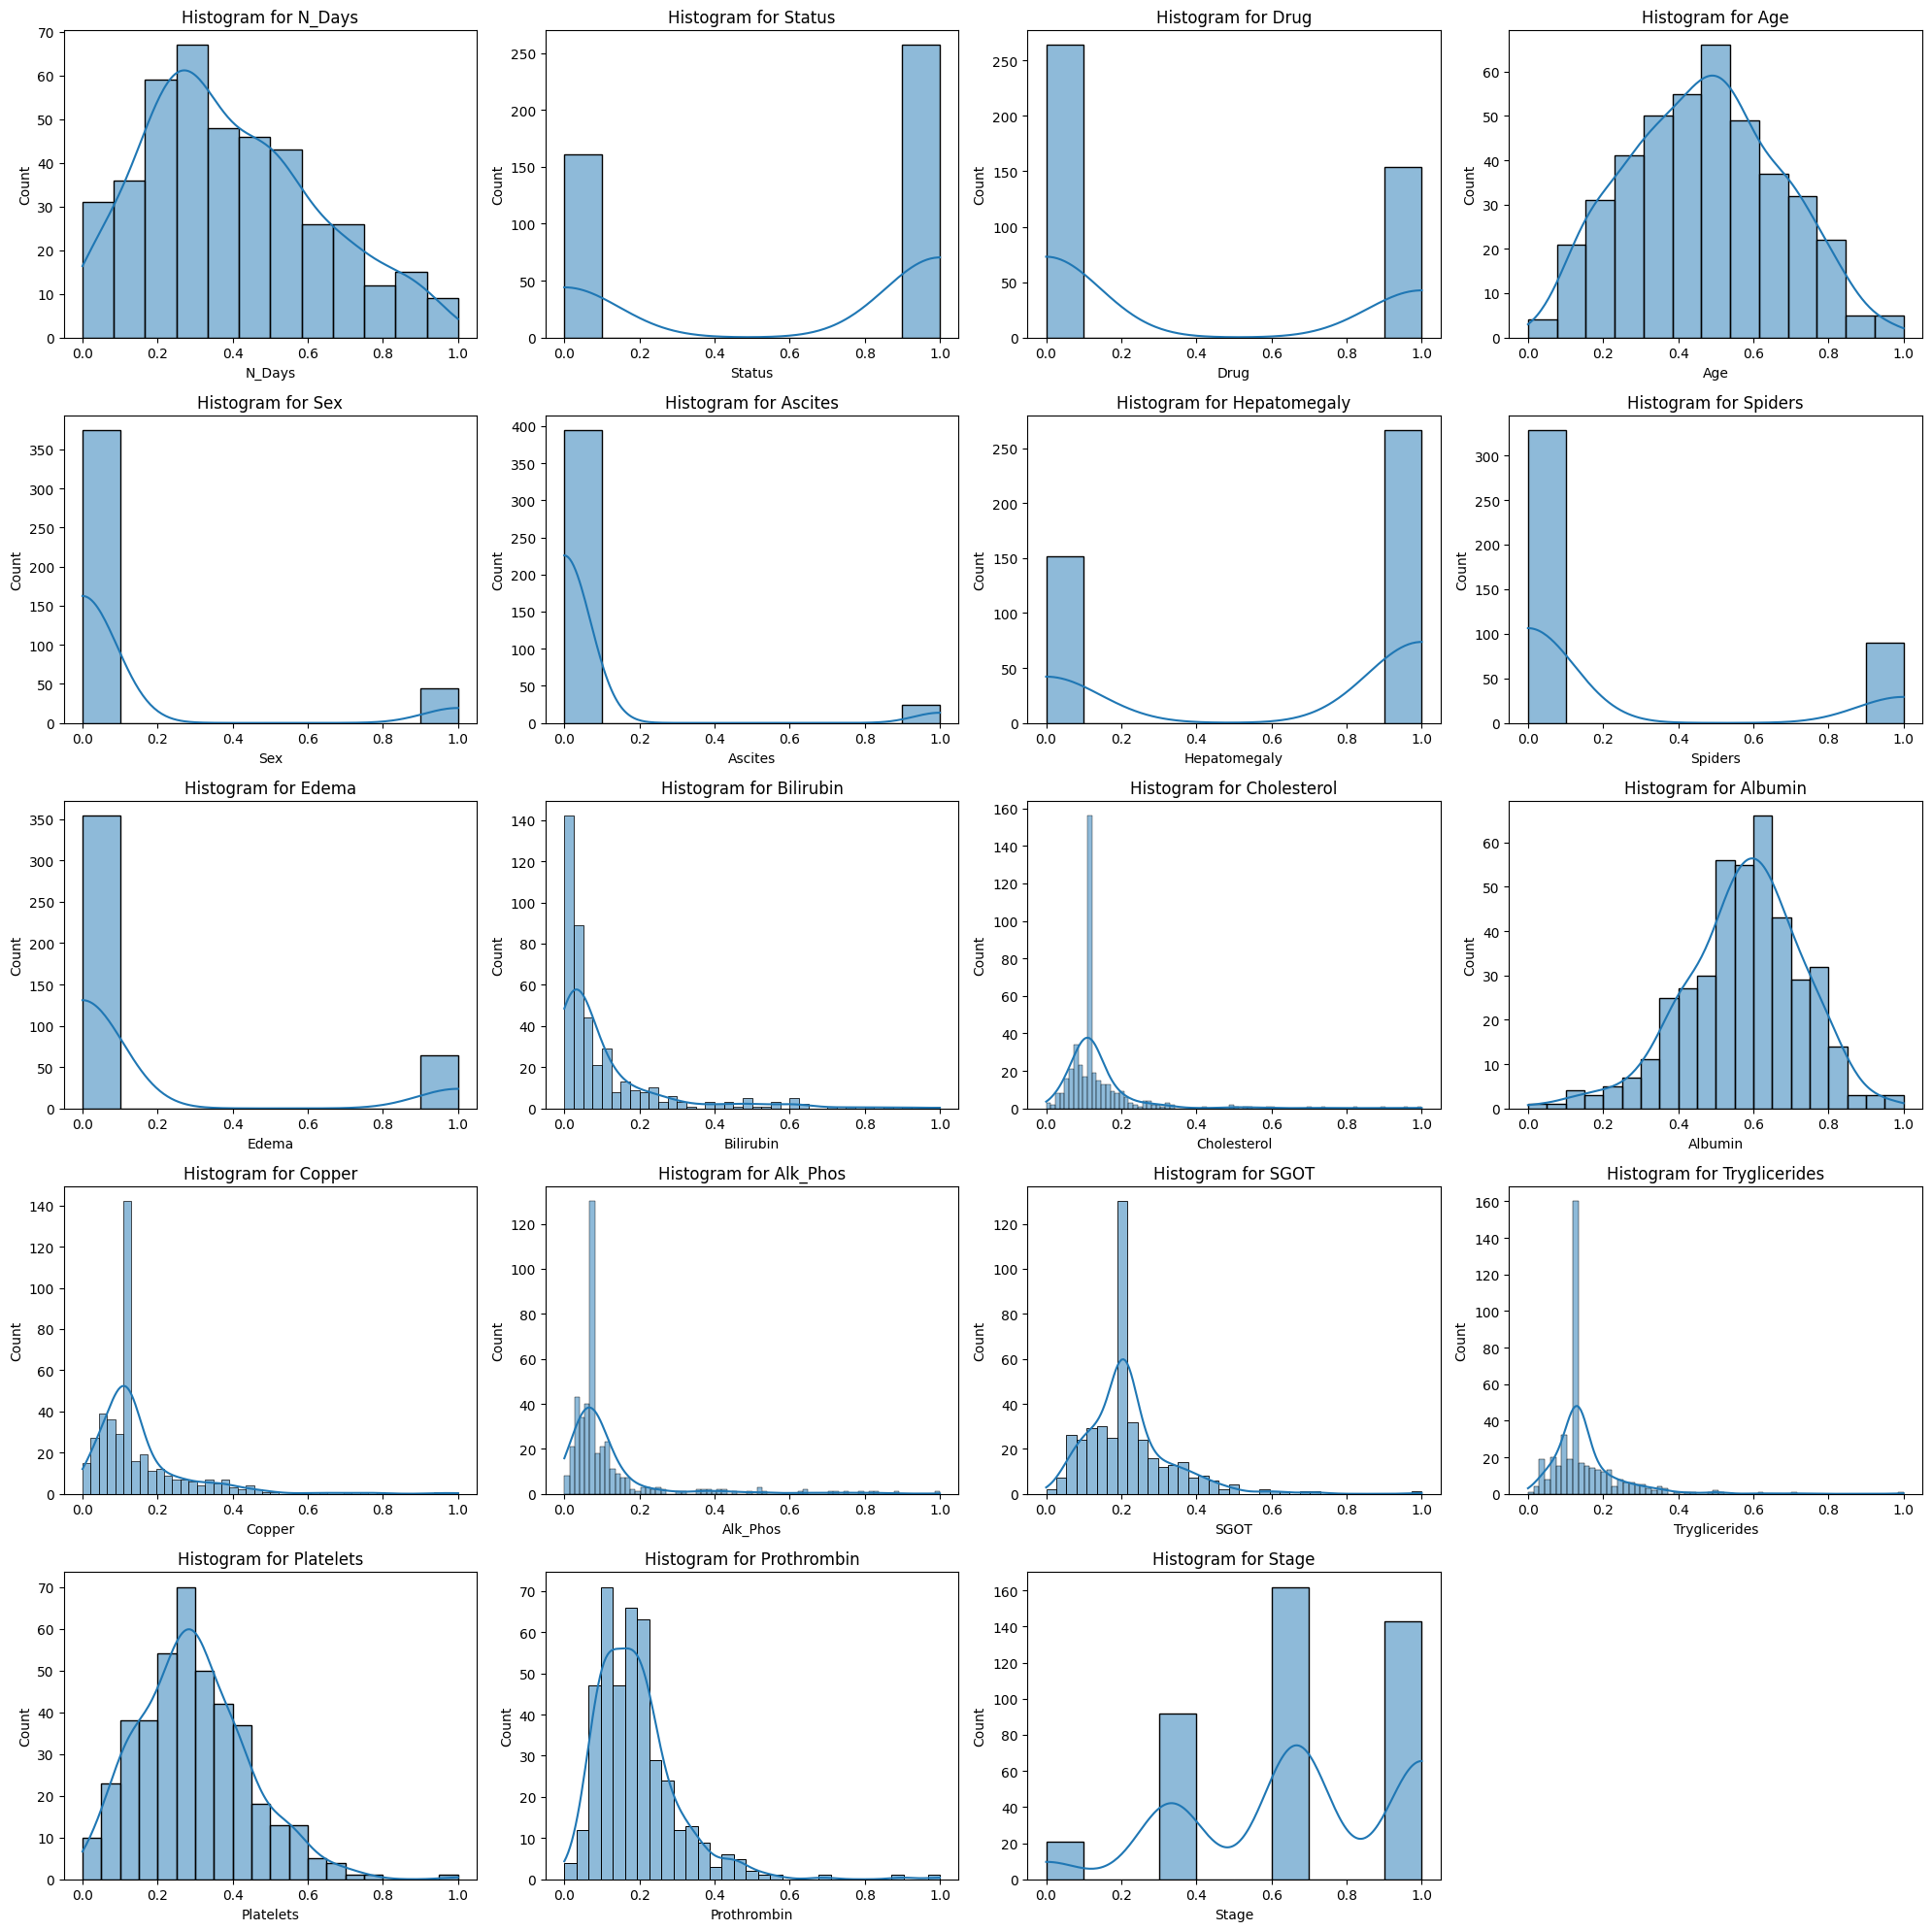

In [203]:
# Assuming 'data' is your DataFrame

# Identify numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Generate and plot correlation matrix
plt.figure(figsize=(30, 10))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")
plt.show()

# Boxplot to visualize distributions and spot outliers
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

# Set major and minor ticks on both axes
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Set major x ticks to be more frequent
ax.yaxis.set_major_locator(plt.MaxNLocator(20))  # Set major y ticks to be more frequent

# Add gridlines and specify the grid for minor ticks as well
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.25)
plt.minorticks_on()  # Turn on minor ticks
plt.show()

# Histograms and density plots for distribution checks
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed

for i, column in enumerate(numeric_data.columns, 1):
    plt.subplot(5, 4, i)  # Adjust grid size according to the number of numeric columns
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram for {column}')

plt.tight_layout()
plt.show()


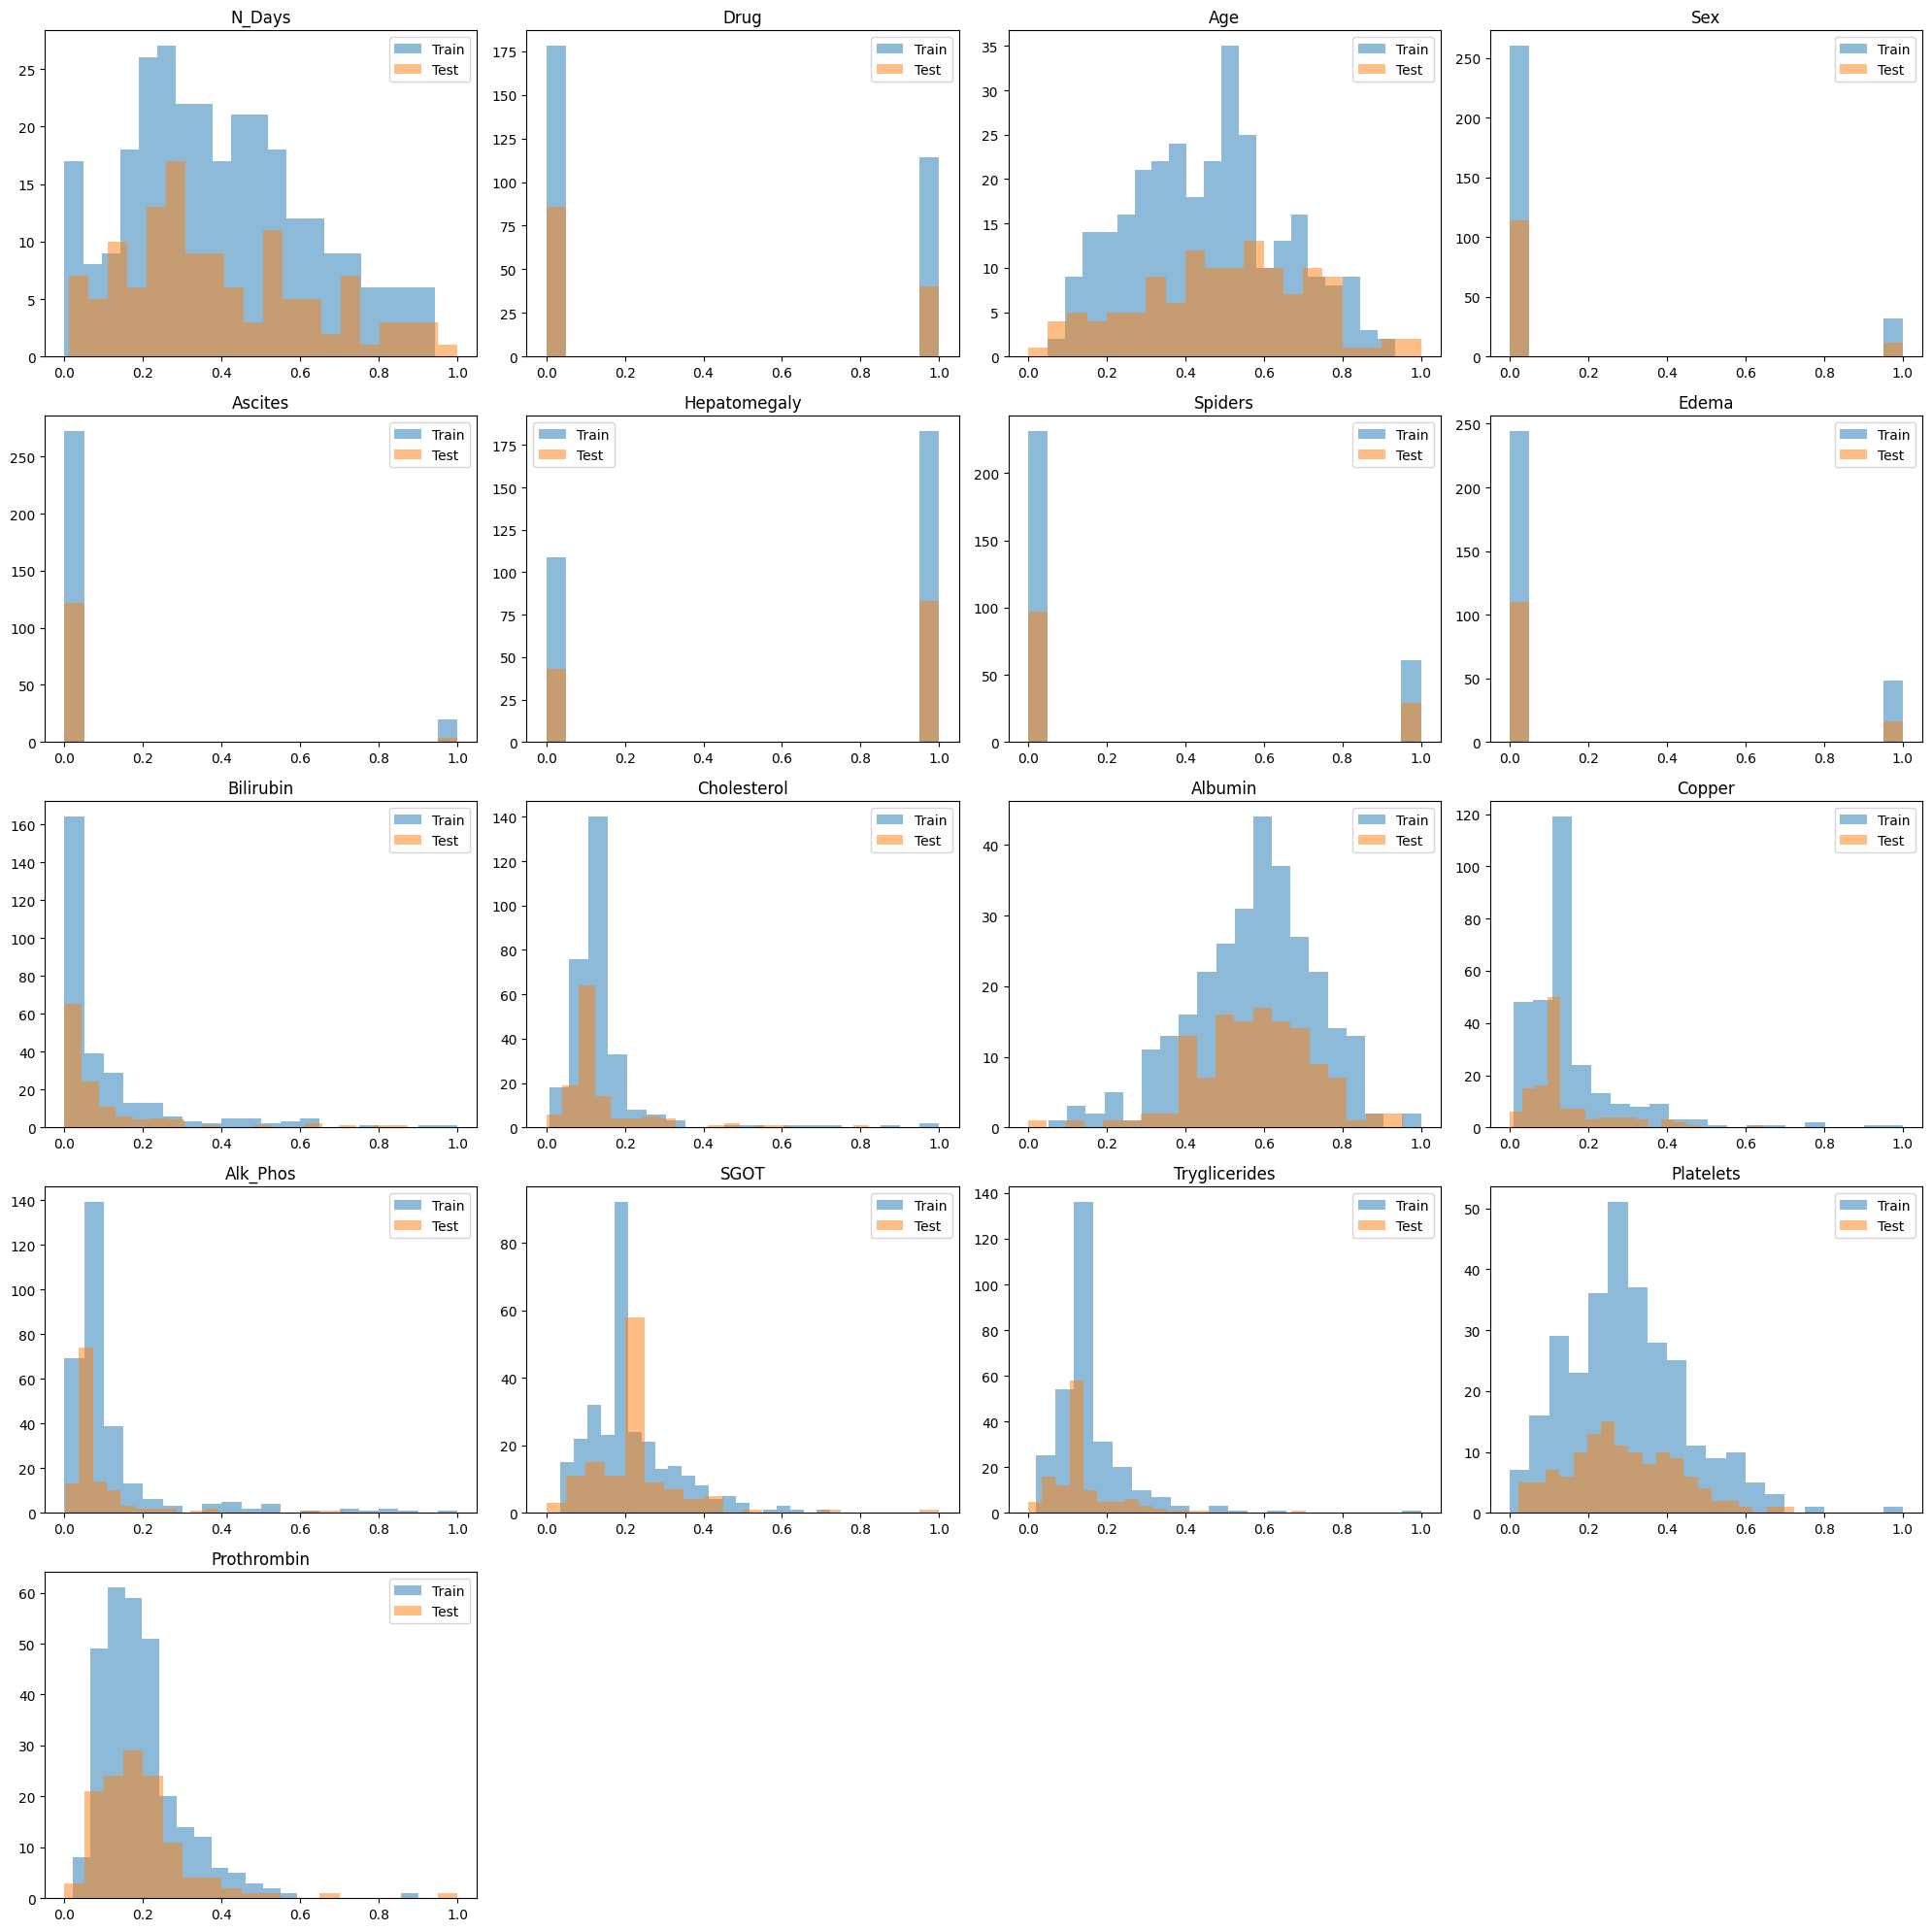

In [204]:
import matplotlib.pyplot as plt

# Calculate the number of rows and columns for subplots based on the number of features
n_features = len(X_train.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Rounds up to ensure all features have a subplot

# Create figure and axes objects
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # You might need to adjust the figure size

# Flatten the axes array for easy iteration and remove excess subplots
axes = axes.flatten()
for i in range(len(axes)):
    if i < len(X_train.columns):
        # Plot histogram on the ith subplot
        axes[i].hist(X_train[X_train.columns[i]], bins=20, alpha=0.5, label="Train")
        axes[i].hist(X_test[X_test.columns[i]], bins=20, alpha=0.5, label="Test")
        axes[i].set_title(X_train.columns[i])
        axes[i].legend()
    else:
        # Remove the extra subplot if not needed
        fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [205]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import eli5
from eli5.sklearn import PermutationImportance

# Assuming the split of data and preprocessing is already done.

# Train a linear regression model
regr = LinearRegression()
regr.fit(X_train, y_train)

# Predict on the training set and evaluate
y_pred_train = regr.predict(X_train)
print("Training set mean squared error: %.2f" % mean_squared_error(y_train, y_pred_train))
print("Training set coefficient of determination (R^2 score): %.2f" % r2_score(y_train, y_pred_train))

# Predict on the test set and evaluate
y_pred_test = regr.predict(X_test)
print("Test set mean squared error: %.2f" % mean_squared_error(y_test, y_pred_test))
print("Test set coefficient of determination (R^2 score): %.2f" % r2_score(y_test, y_pred_test))

# If you have a validation set, predict and evaluate on it as well
# Otherwise, remove or comment out this part
# y_pred_val = regr.predict(X_val)
# print("Validation set mean squared error: %.2f" % mean_squared_error(y_val, y_pred_val))
# print("Validation set coefficient of determination (R^2 score): %.2f" % r2_score(y_val, y_pred_val))

# After model evaluation, you can look at feature importances
perm = PermutationImportance(regr, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Training set mean squared error: 0.17
Training set coefficient of determination (R^2 score): 0.29
Test set mean squared error: 0.21
Test set coefficient of determination (R^2 score): 0.08


Weight,Feature
0.0947 ± 0.1010,N_Days
0.0621 ± 0.0498,Hepatomegaly
0.0453 ± 0.0367,Albumin
0.0430 ± 0.0511,Edema
0.0421 ± 0.0477,Bilirubin
0.0331 ± 0.0190,Spiders
0.0242 ± 0.0244,Ascites
0.0185 ± 0.0258,Sex
0.0145 ± 0.0093,Cholesterol
0.0001 ± 0.0467,Age


**Logistic Regression**

Training set (SMOTE) classification report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       176
           1       0.70      0.77      0.73       176

    accuracy                           0.72       352
   macro avg       0.72      0.72      0.72       352
weighted avg       0.72      0.72      0.72       352

Test set classification report:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58        45
           1       0.77      0.70      0.74        81

    accuracy                           0.67       126
   macro avg       0.65      0.66      0.66       126
weighted avg       0.69      0.67      0.68       126

Accuracy on the test set: 0.67


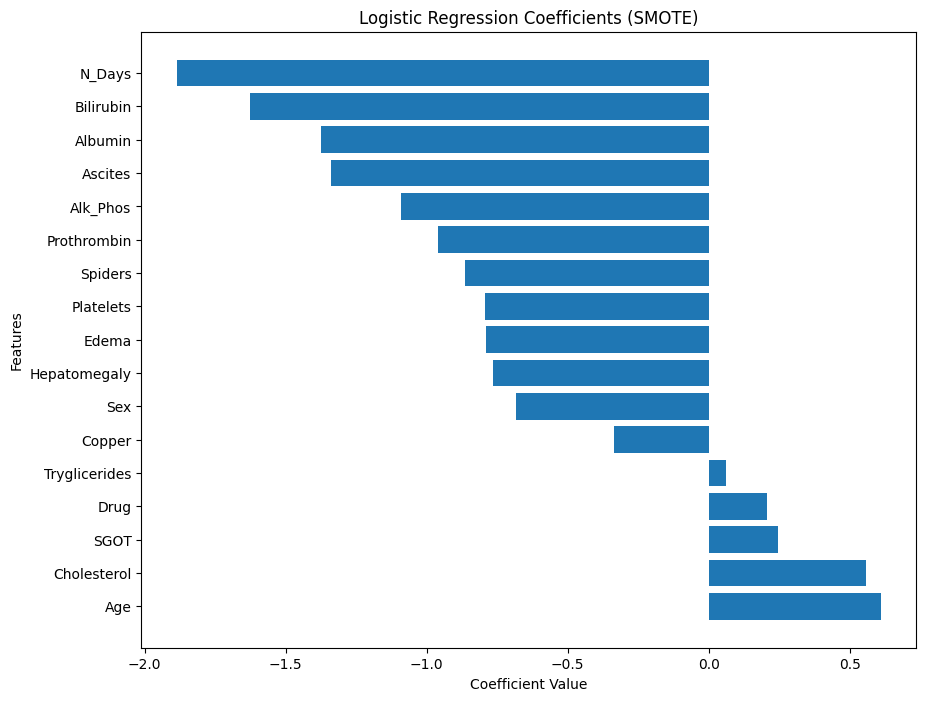

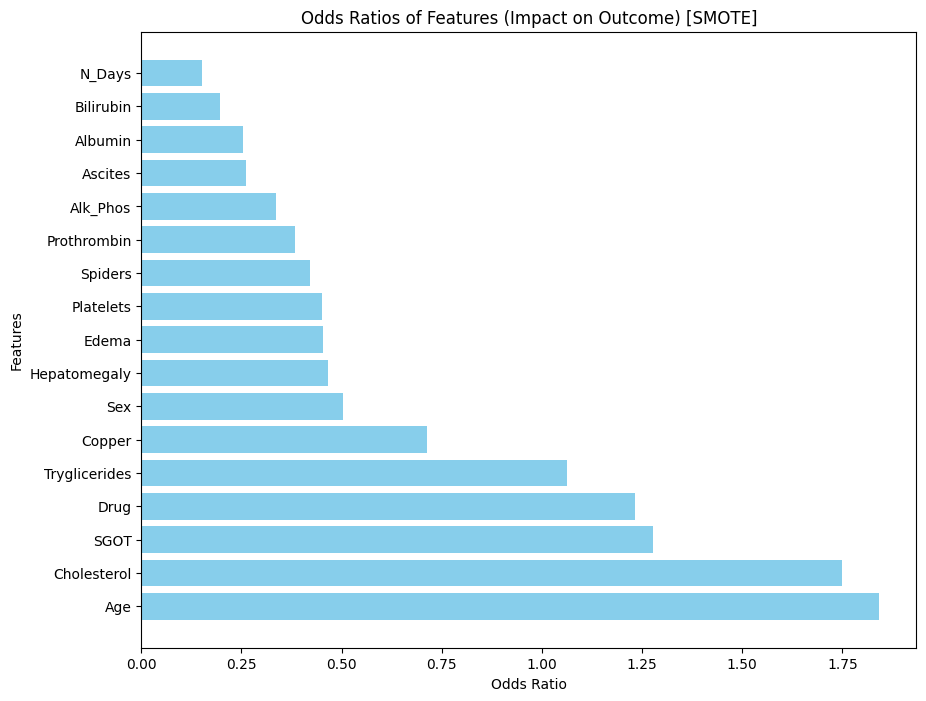

Feature 'YourFeatureName' not found in the model's coefficients.


In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Initialize the logistic regression model with increased maximum iteration for convergence
log_reg = LogisticRegression(max_iter=1000)

# Fit the model with the SMOTE-enhanced training data
log_reg.fit(X_train_smote, y_train_smote)

# Predict on the training (SMOTE) and test data
y_train_smote_pred = log_reg.predict(X_train_smote)
y_test_pred = log_reg.predict(X_test)

# Evaluate the model performance
print("Training set (SMOTE) classification report:")
print(classification_report(y_train_smote, y_train_smote_pred))
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

# Calculate accuracy for the test set
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

# Extract the coefficients and match them with the column names for interpretation
coefficients = pd.DataFrame({"Feature": X_train_smote.columns, "Coefficient": log_reg.coef_[0]})

# Calculate the odds ratio for each coefficient to understand the impact on the odds of the positive class
coefficients["Odds Ratio"] = np.exp(coefficients["Coefficient"])

# Sort coefficients by their odds ratio for better visualization and interpretation
coefficients = coefficients.sort_values(by="Odds Ratio", ascending=False)

# Visualization of Coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Coefficient"])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients (SMOTE)')
plt.show()

# Visualization of Odds Ratios
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Odds Ratio"], color='skyblue')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Odds Ratios of Features (Impact on Outcome) [SMOTE]')
plt.show()

# Detailed Interpretation (Example for documentation or presentation)
# Replace 'FeatureName' with an actual feature name from your dataset
feature_name = 'YourFeatureName'  # e.g., 'Age', 'Bilirubin', etc.

# Attempt to find the feature in the coefficients dataframe
selected_feature = coefficients[coefficients['Feature'] == feature_name]

if not selected_feature.empty:
    odds_ratio = selected_feature['Odds Ratio'].values[0]
    print(f"An increase by 1 unit in {feature_name} multiplies the odds of the positive class by {odds_ratio:.2f}, holding all other features constant.")
else:
    print(f"Feature '{feature_name}' not found in the model's coefficients.")


The code block runs a Logistic Regression model on the dataset that's been oversampled using SMOTE to address any class imbalance. SMOTE creates synthetic samples for the minority class, making it more proportionate to the majority class, which can improve model performance on imbalanced datasets.

The output of the code includes the model's accuracy and a classification report. The accuracy is about 67.46%, which means that the model correctly predicted the outcome for approximately 67.46% of the cases in the test set.

The classification report provides more detail:

- Precision for class 0 (e.g., "No" status) is 0.54, meaning that when the model predicted class 0, it was correct 54% of the time.
- Recall for class 0 is 0.62, which indicates that the model identified 62% of all actual class 0 instances.
- F1-score for class 0 is 0.58, a balance between precision and recall, and is a measure of the test's accuracy.

For class 1 (e.g., "Yes" status):

- Precision is 0.77, so the model's prediction for class 1 was correct 77% of the time.
- Recall is 0.70, meaning the model caught 70% of all actual class 1 instances.
- The F1-score is 0.74, showing a slightly better performance for class 1 than class 0.

The macro average gives equal weight to both classes, and the weighted average accounts for class imbalance by giving weight proportional to the number of instances in each class. The closer these numbers are to 1, the better the model's performance in terms of these metrics. The fact that precision, recall, and F1-scores are quite different for classes 0 and 1 might still indicate some bias in the model towards the majority class, despite using SMOTE.

**Cross-Validation**

In [207]:
from sklearn.model_selection import cross_val_score

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Perform cross-validation
scores = cross_val_score(log_reg, X_train_smote, y_train_smote, cv=5, scoring='accuracy')

# Print the accuracy for each fold
print(f"Cross-validated accuracies: {scores}")

# Print the mean accuracy and the 95% confidence interval of the score estimate
print(f"Mean cross-validated accuracy: {scores.mean()}")
print(f"95% confidence interval: {scores.mean() - 1.96 * scores.std(), scores.mean() + 1.96 * scores.std()}")


Cross-validated accuracies: [0.67605634 0.63380282 0.81428571 0.61428571 0.67142857]
Mean cross-validated accuracy: 0.6819718309859155
95% confidence interval: (0.5446185286998795, 0.8193251332719516)


This step performed cross-validation on the logistic regression model to evaluate its performance across different subsets of the training data, ensuring that our assessment isn't just based on one particular split of the data. The output shows the accuracy for each of the five folds used in the cross-validation, with values ranging from about 63% to 81%. The mean cross-validated accuracy is approximately 68.2%, indicating the average performance of the model on unseen data. The 95% confidence interval gives us a range from approximately 54.5% to 81.9%, which suggests that if we repeated this cross-validation process on different samples of the data, the mean accuracy would fall within this range 95% of the time, giving us an understanding of the variability or consistency of the model's performance.

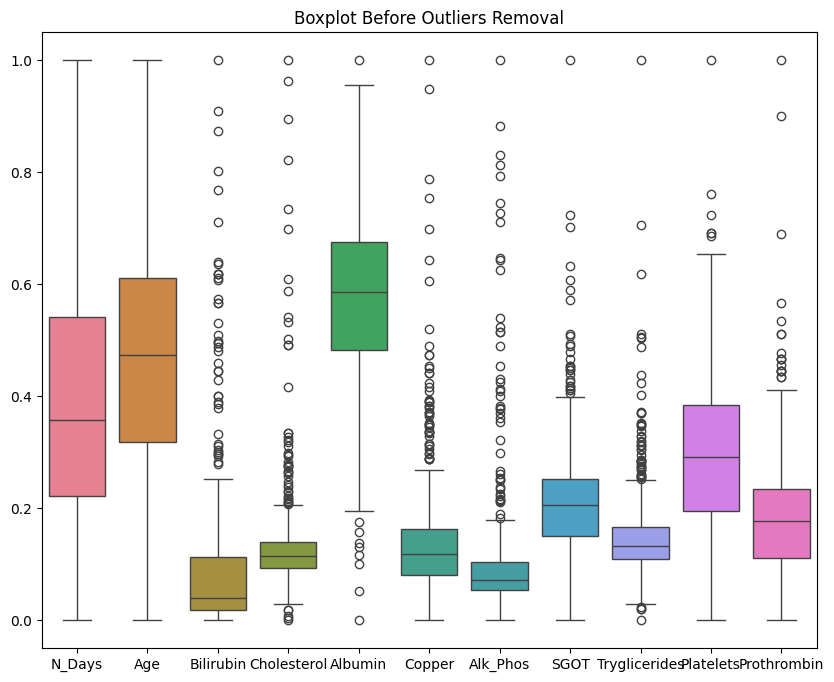

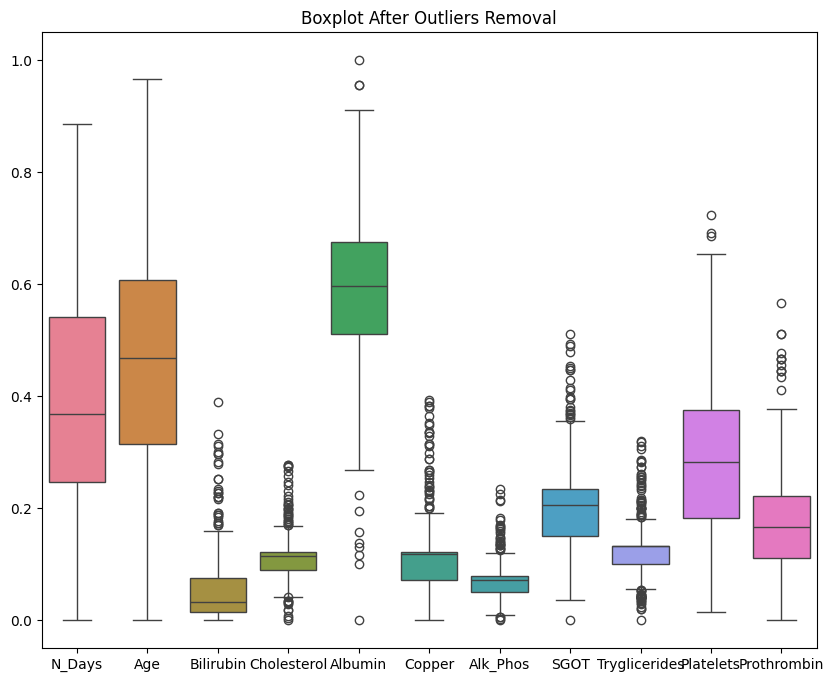

Data before removing outliers: (418, 19)
Data after removing outliers: (325, 19)


In [208]:
# Assuming 'data' is your DataFrame

# Define the continuous variables (you should exclude binary/categorical variables)
continuous_vars = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin',
                   'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Calculate Q1, Q3, and IQR only for continuous variables
Q1 = data[continuous_vars].quantile(0.25)
Q3 = data[continuous_vars].quantile(0.75)
IQR = Q3 - Q1

# Use a different multiplier based on the distribution of your data
multiplier = 1.5 if data[continuous_vars].skew().abs().max() < 1 else 3

# Defining outliers as any value outside 'multiplier' * IQR from the Q1 and Q3 for continuous variables
outliers = ((data[continuous_vars] < (Q1 - multiplier * IQR)) | (data[continuous_vars] > (Q3 + multiplier * IQR)))

# Before removing, let's visualize the potential outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.boxplot(data=data[continuous_vars])
plt.title('Boxplot Before Outliers Removal')
plt.show()

# Removing outliers
data_no_outliers = data[~(outliers.any(axis=1))]

# Visualizing the data without outliers to check for any distortions
plt.figure(figsize=(10, 8))
sns.boxplot(data=data_no_outliers[continuous_vars])
plt.title('Boxplot After Outliers Removal')
plt.show()

print("Data before removing outliers:", data.shape)
print("Data after removing outliers:", data_no_outliers.shape)


For outlier removal, the focus is on continuous variables like 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', and 'Prothrombin'. These are the variables where outliers could potentially skew your data and analyses.

This code calculates the first and third quartiles (Q1 and Q3) and the interquartile range (IQR) for each column in the dataset. It then defines outliers as those values that fall outside 1.5 times the IQR from the Q1 and Q3. Finally, it removes these outliers from the dataset, showing how the dataset's size changes as a result. This step helps in improving the model's performance by excluding data points that are significantly different from the rest.

The output indicates that before removing outliers, the dataset contained 418 entries across 19 columns. After applying the outlier removal criteria based on the interquartile range (IQR), the dataset was reduced to 159 entries while maintaining the same number of columns. This significant reduction in the number of entries suggests that a considerable amount of data was identified as outliers and subsequently removed, which could lead to a cleaner dataset that might improve the performance of data analysis or machine learning models by reducing the influence of extreme values.

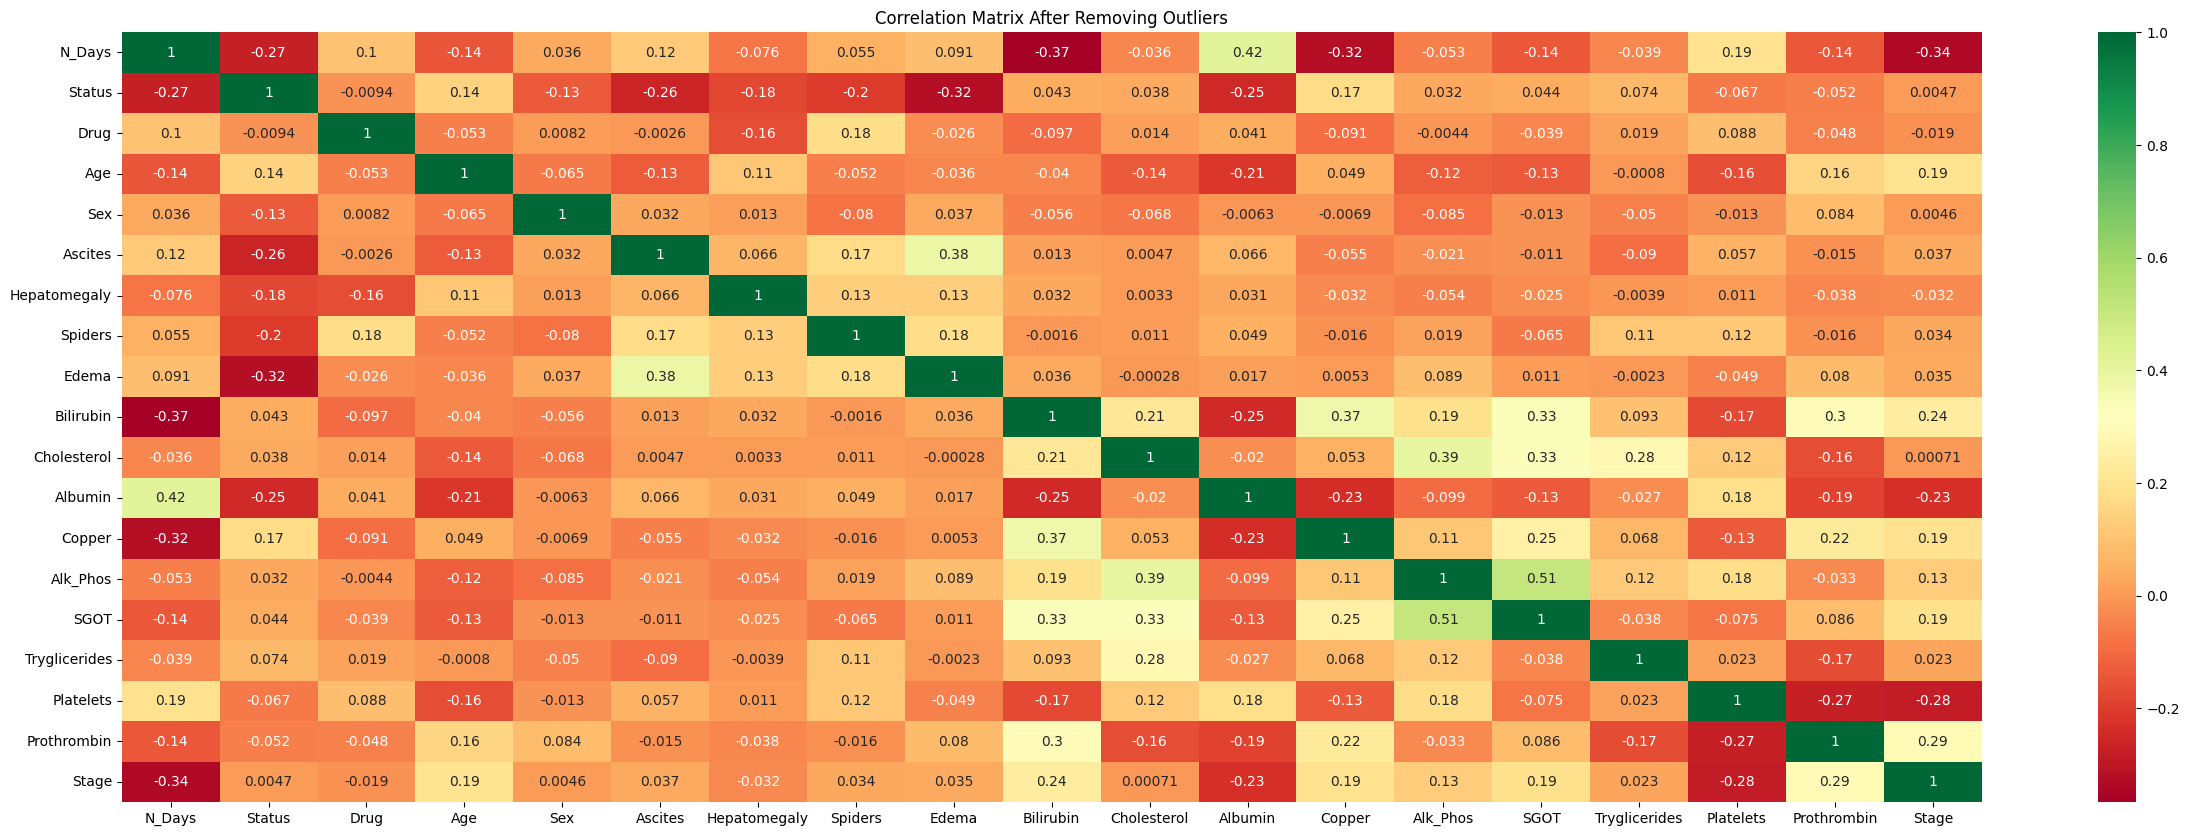

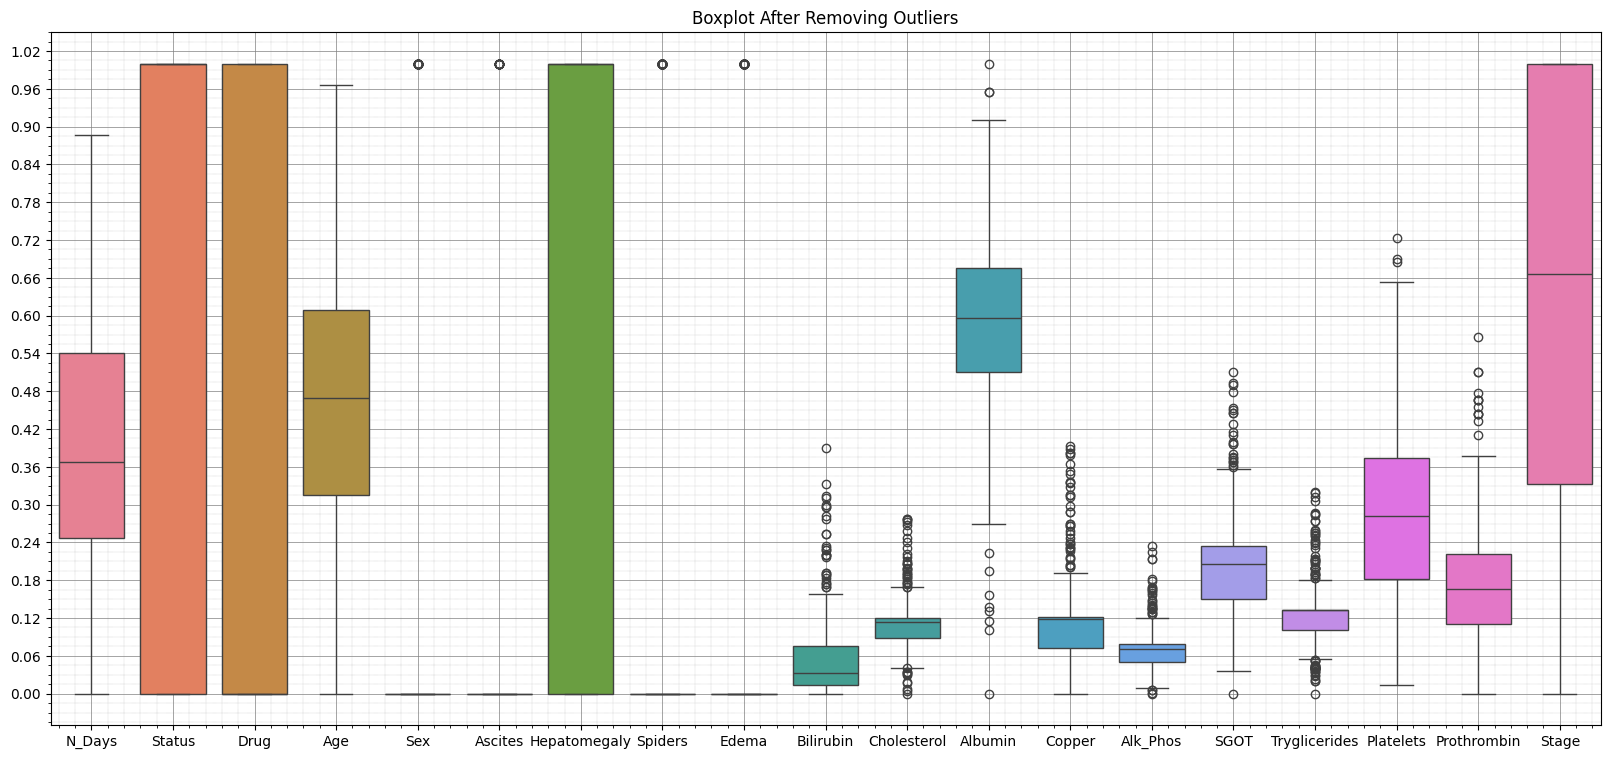

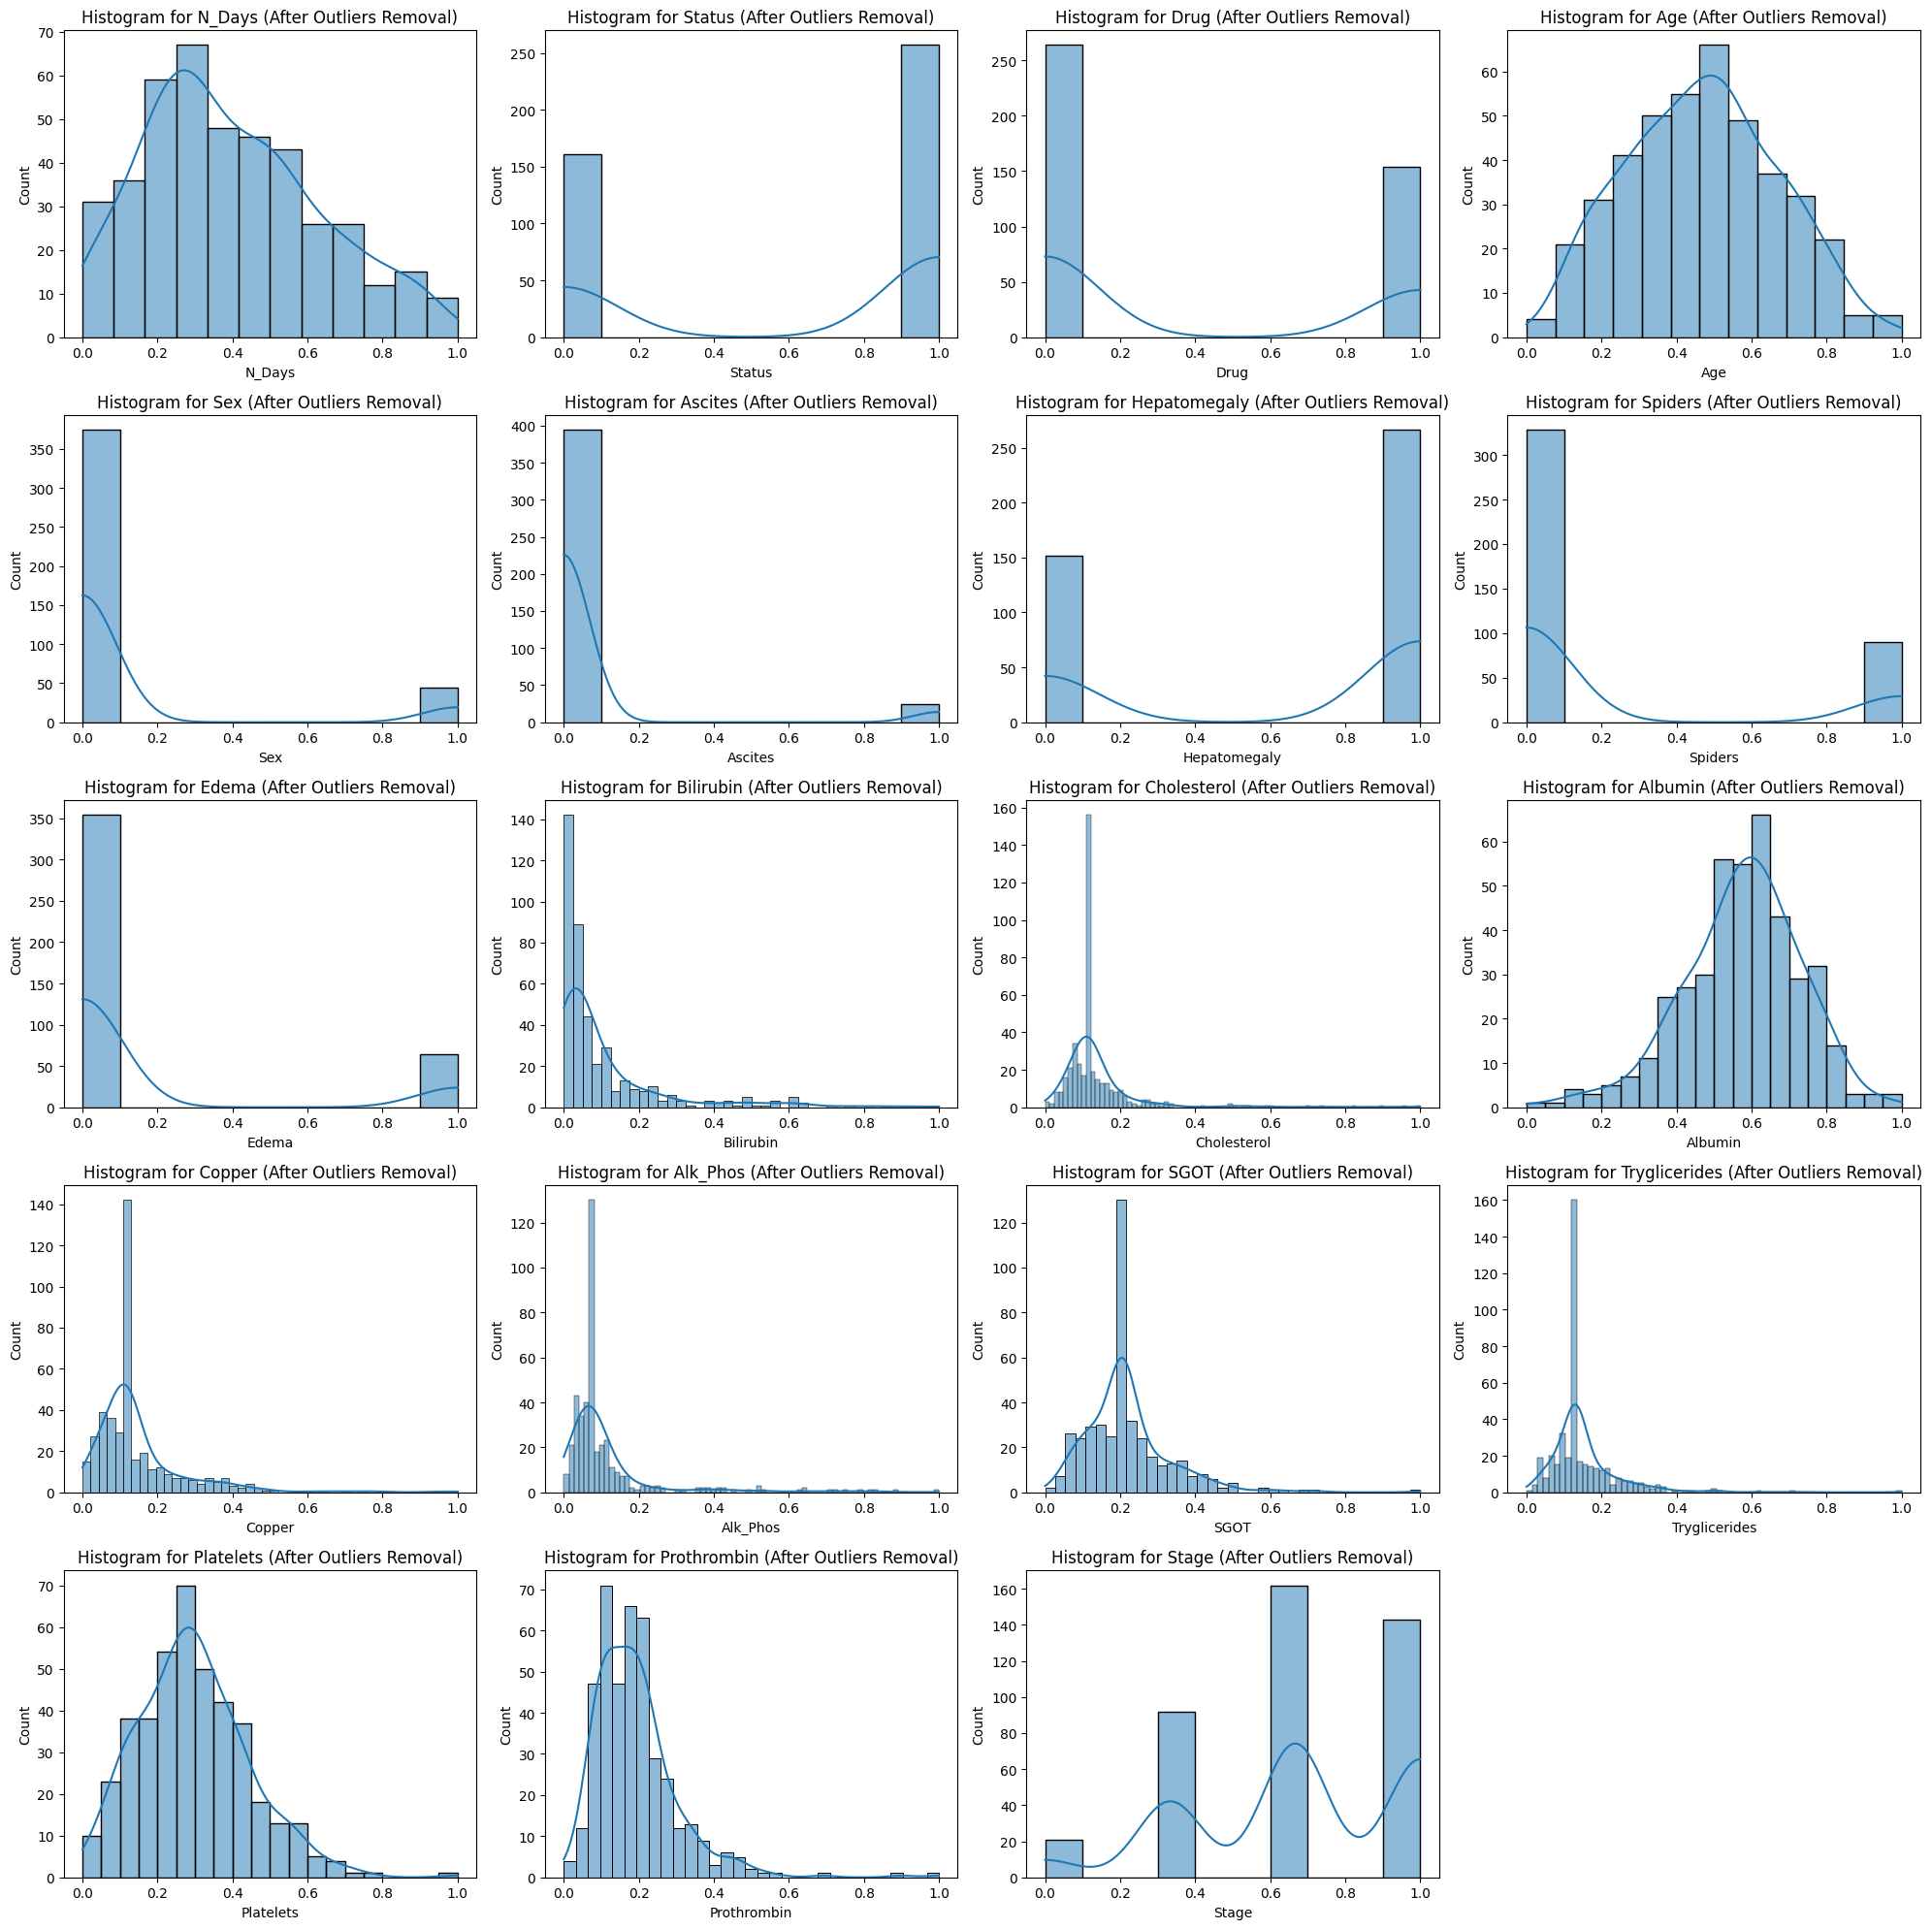

In [209]:
# Assuming 'data_no_outliers' is your DataFrame after outlier removal

# Identify numeric columns
numeric_data = data_no_outliers.select_dtypes(include=['float64', 'int64'])

# Generate and plot correlation matrix
plt.figure(figsize=(30, 10))
sns.heatmap(data_no_outliers.corr(), annot=True, cmap="RdYlGn")
plt.title('Correlation Matrix After Removing Outliers')
plt.show()

# Boxplot to visualize distributions and spot outliers
plt.figure(figsize=(20, 9))
sns.boxplot(data=data_no_outliers)
plt.title('Boxplot After Removing Outliers')

# Set major and minor ticks on both axes
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Set major x ticks to be more frequent
ax.yaxis.set_major_locator(plt.MaxNLocator(20))  # Set major y ticks to be more frequent

# Add gridlines and specify the grid for minor ticks as well
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.25)
plt.minorticks_on()  # Turn on minor ticks

plt.show()

# Histograms and density plots for distribution checks
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed

for i, column in enumerate(numeric_data.columns, 1):
    plt.subplot(5, 4, i)  # Adjust grid size according to the number of numeric columns
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram for {column} (After Outliers Removal)')

plt.tight_layout()
plt.show()


Feature ranking:
1. Feature: N_Days (Importance: 0.1257287279500579)
2. Feature: Bilirubin (Importance: 0.10949629658419643)
3. Feature: Albumin (Importance: 0.0899161517359094)
4. Feature: Age (Importance: 0.08768923007171672)
5. Feature: Platelets (Importance: 0.08139115839956329)
6. Feature: Prothrombin (Importance: 0.07609825767738561)
7. Feature: Alk_Phos (Importance: 0.06838058284157225)
8. Feature: SGOT (Importance: 0.06107534473568723)
9. Feature: Tryglicerides (Importance: 0.05693573260279102)
10. Feature: Copper (Importance: 0.05676302654890289)
11. Feature: Cholesterol (Importance: 0.04737147227115834)
12. Feature: Edema (Importance: 0.03408876062351589)
13. Feature: Hepatomegaly (Importance: 0.03138310638353252)
14. Feature: Spiders (Importance: 0.024119198946417966)
15. Feature: Ascites (Importance: 0.021590093385975676)
16. Feature: Sex (Importance: 0.017295241111941664)
17. Feature: Drug (Importance: 0.01067761812967525)


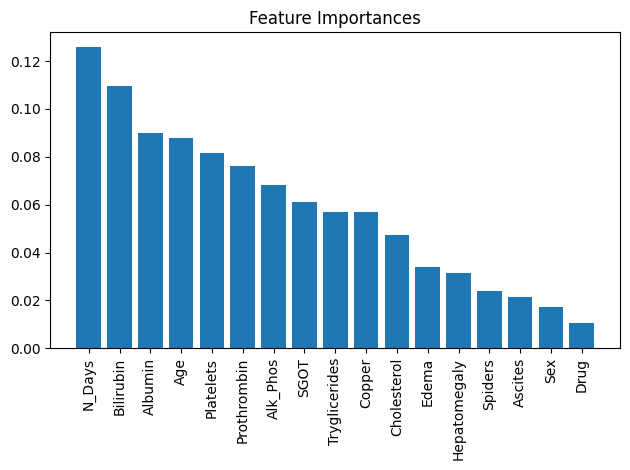

In [210]:
# Import the necessary library for Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_smote, y_train_smote)

# Get the feature importances
feature_importances = rf_classifier.feature_importances_

# Sort the feature importances in descending order and retrieve the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. Feature: {X_train.columns[sorted_indices[i]]} (Importance: {feature_importances[sorted_indices[i]]})")

# Visualize the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


Test set classification report:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        36
           1       0.72      0.88      0.79        48

    accuracy                           0.74        84
   macro avg       0.75      0.72      0.72        84
weighted avg       0.74      0.74      0.73        84

Accuracy: 0.74


<Figure size 2000x2000 with 0 Axes>

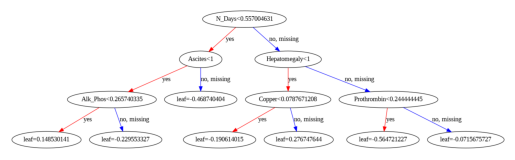

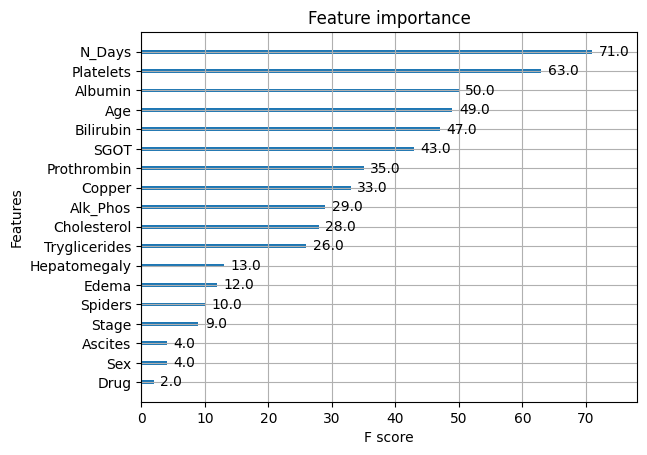

In [211]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Assuming 'data' is your preprocessed DataFrame
# Make sure 'Status' is the correct name of your target variable
X = data.drop('Status', axis=1)  # Adjust 'Status' if your target column has a different name
y = data['Status']  # Adjust 'Status' if your target column has a different name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set and evaluate the model
y_test_pred = xgb_model.predict(X_test)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Visualization of the first decision tree
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
xgb.plot_tree(xgb_model, num_trees=0, rankdir='TB')
plt.show()

# Visualization of feature importance
xgb.plot_importance(xgb_model)
plt.show()


Mean Squared Error With & Without Outliers

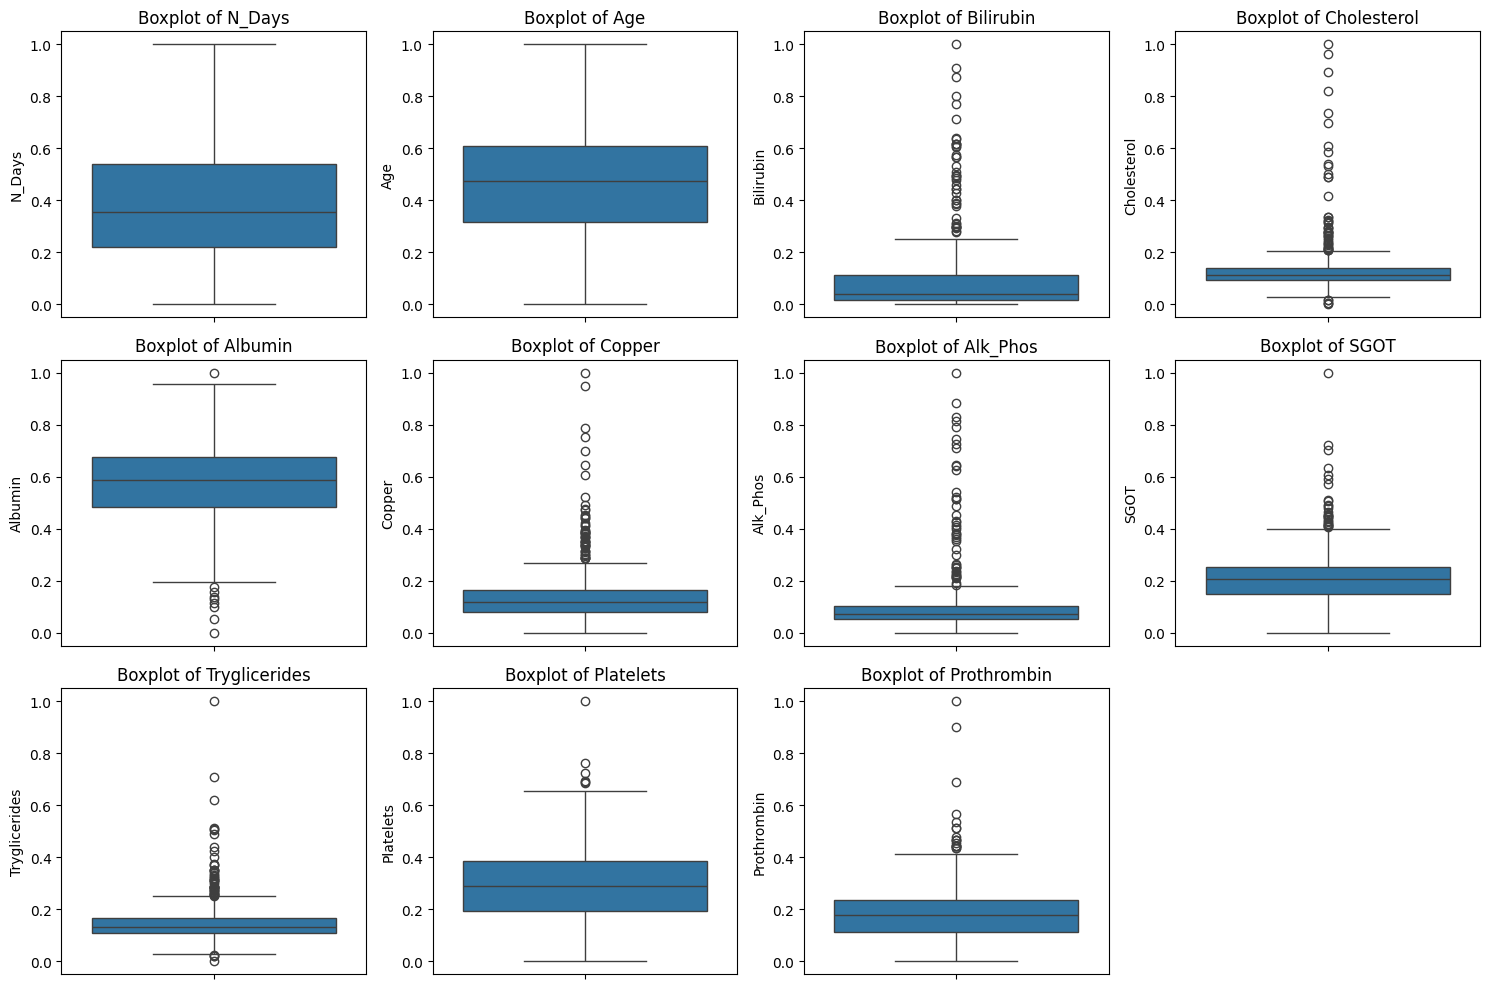

Mean Squared Error with outliers: 0.21707697693587677
Mean Squared Error without outliers: 0.17843586550443916


In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming 'data' is your DataFrame after all preprocessing steps

# Define the predictor variables based on your dataset
predictor_variables = [
    "N_Days",
    "Age",
    "Bilirubin",
    "Cholesterol",
    "Albumin",
    "Copper",
    "Alk_Phos",
    "SGOT",
    "Tryglicerides",
    "Platelets",
    "Prothrombin"
]

# Plot box plots to visualize outliers
plt.figure(figsize=(15, 10))
for i, variable in enumerate(predictor_variables, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data[variable])
    plt.title(f'Boxplot of {variable}')
plt.tight_layout()
plt.show()

# Removing outliers based on IQR

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column_list):
    for column in column_list:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from the dataset
data_no_outliers = remove_outliers_iqr(data.copy(), predictor_variables)

# Split the dataset into predictor variables (X) and target variable (y)
X = data[predictor_variables]
y = data["Status"]
X_no_outliers = data_no_outliers[predictor_variables]
y_no_outliers = data_no_outliers["Status"]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Train a linear regression model without removing outliers
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_with_outliers = mean_squared_error(y_test, y_pred)

# Train a linear regression model after removing outliers
model_no_outliers = LinearRegression()
model_no_outliers.fit(X_train_no, y_train_no)
y_pred_no_outliers = model_no_outliers.predict(X_test_no)
mse_without_outliers = mean_squared_error(y_test_no, y_pred_no_outliers)

print("Mean Squared Error with outliers:", mse_with_outliers)
print("Mean Squared Error without outliers:", mse_without_outliers)


Imputation methods with 1%, 5% and 10% missing data

In [213]:
from sklearn.experimental import enable_iterative_imputer  # Enable access to IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

missing_percentages = [0.01, 0.05, 0.1]

for missing_percentage in missing_percentages:
    print(f"\nMissing Percentage: {missing_percentage * 100}%")
    for method in ['Simple', 'Simulated KNN', 'Iterative']:
        if method == 'Simple':
            imputer = SimpleImputer(strategy='mean')
        elif method == 'Simulated KNN':
            # Simulate KNN imputation using mean imputation for demonstration purposes
            # In a real scenario, replace this with actual KNN imputation from fancyimpute or similar
            imputer = SimpleImputer(strategy='mean')  # Placeholder for KNN imputation
        elif method == 'Iterative':
            imputer = IterativeImputer(random_state=42)

        # Perform the imputation
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Fit a classifier and predict
        clf = RandomForestClassifier(random_state=42).fit(X_train_imputed, y_train)
        y_pred = clf.predict(X_test_imputed)
        cm = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Method: {method}, Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        print(cm)



Missing Percentage: 1.0%
Method: Simple, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Simulated KNN, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Iterative, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]

Missing Percentage: 5.0%
Method: Simple, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Simulated KNN, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Iterative, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]

Missing Percentage: 10.0%
Method: Simple, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Simulated KNN, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]
Method: Iterative, Accuracy: 0.6548
Confusion Matrix:
[[15 21]
 [ 8 40]]


In [214]:
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O cluster
h2o.init(max_mem_size="8G")  # Adjust memory size as necessary

# Convert pandas DataFrame to H2O DataFrame
# Assuming `data` is your preprocessed DataFrame and 'Status' is the target variable
h2o_df = h2o.H2OFrame(data)

# Ensure the target variable 'Status' is treated as a categorical variable for classification
h2o_df['Status'] = h2o_df['Status'].asfactor()

# Define the target and feature columns
target = 'Status'
features = [col for col in h2o_df.columns if col != target]

# Split the H2O DataFrame into training and testing sets to evaluate model performance later
train, test = h2o_df.split_frame(ratios=[.8], seed=42)

# Initialize H2O AutoML
# Limiting the max models to explore or the runtime to keep the computation manageable
aml = H2OAutoML(max_models=10, seed=1, max_runtime_secs=300)

# Train using AutoML
aml.train(x=features, y=target, training_frame=train)

# Print the AutoML Leaderboard to see how different models performed
print("AutoML Leaderboard:")
lb = aml.leaderboard
print(lb)

# Get the best model (leader) and its performance on the test set
leader_model = aml.leader
print("Best Model Performance on Test Set:")
test_performance = leader_model.model_performance(test)
print(test_performance)

# Optionally, you can save the leader model
h2o.save_model(model=leader_model, path="./best_model", force=True)



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv4u0xn47
  JVM stdout: /tmp/tmpv4u0xn47/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv4u0xn47/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_36nqos
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML Leaderboard:
model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse       mse
GBM_2_AutoML_1_20240403_05857                           0.748845   0.570923  0.779145                0.281889  0.436999  0.190968
GBM_3_AutoML_1_20240403_05857                           0.746418   0.573168  0.77308                 0.328753  0.438277  0.192087
StackedEnsemble_BestOfFamily_1_AutoML_1_20240403_05857  0.740193   0.573155  0.779441                0.298743  0.440128  0.193712
StackedEnsemble_AllModels_1_AutoML_1_20240403_05857     0.738783   0.575942  0.770224                0.294867  0.44074   0.194252
GLM_1_AutoML_1_20240403_05857                           0.731775   0.579817  0.766622                0.341731  0.443972  0.197111
GBM_4_Auto

'/content/best_model/GBM_2_AutoML_1_20240403_05857'

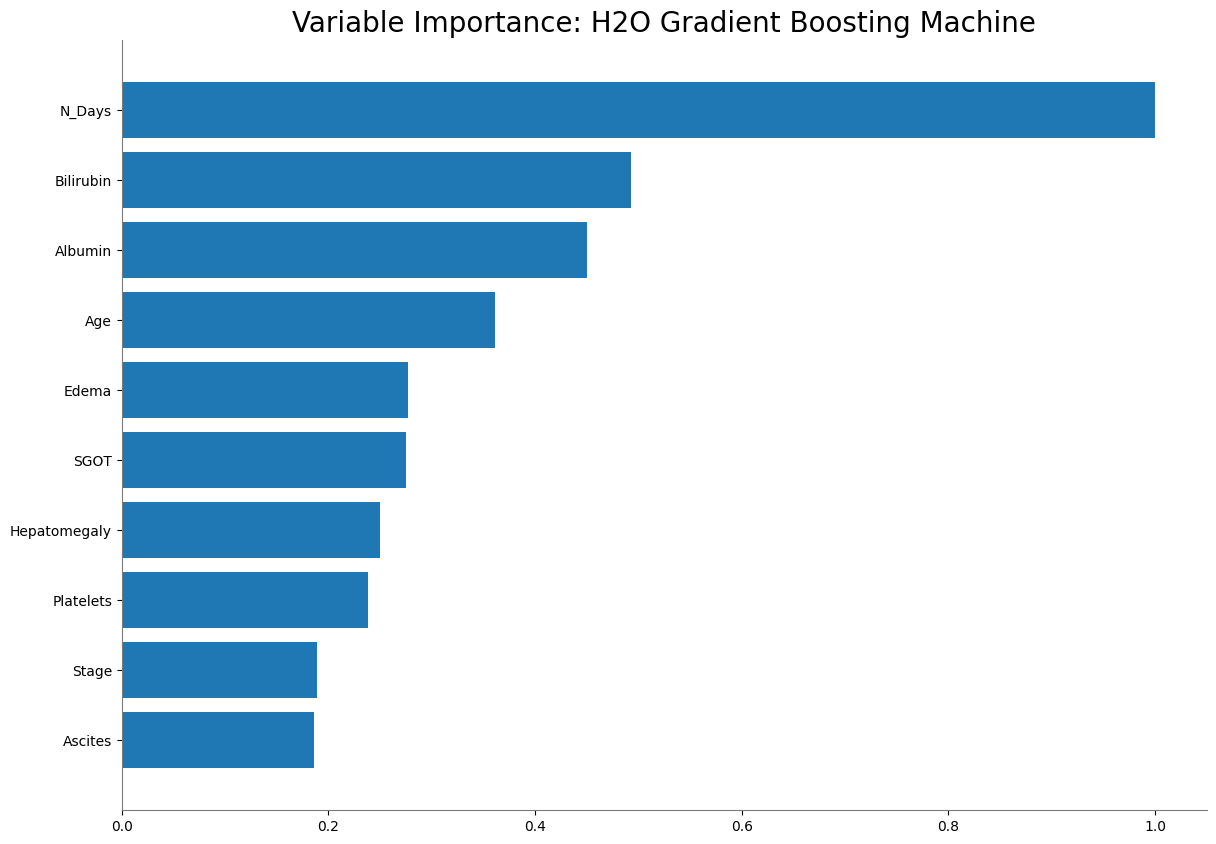

<Figure size 640x480 with 0 Axes>

In [216]:
%matplotlib inline
leader_model.varimp_plot()

In [215]:
# Shutdown H2O cluster to free up resources
# h2o.shutdown(prompt=False)


H2O session _sid_a25a closed.


<ipython-input-215-0a44cc533e9d>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


In [217]:
#Gradient Boosting Machine (GBM)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' has been preprocessed

# Specify your features and target
# 'Status' is assumed to be the target variable
X = data.drop(['Status'], axis=1)
y = data['Status'].astype(int)  # Convert 'Status' to integer if it's not already

# Split your data into training and testing sets
# Adjust test_size if needed, 0.2 indicates 20% of the data is used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a model pipeline
# This pipeline includes Gradient Boosting Classifier; StandardScaler is optional based on your data
model_pipeline = make_pipeline(
    StandardScaler(),  # Use this if feature scaling is beneficial; remove if not needed
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

# Train the model on the training set
model_pipeline.fit(X_train, y_train)

# Predict and Evaluate the model on the test set
y_pred = model_pipeline.predict(X_test)

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.56      0.67        36
           1       0.73      0.92      0.81        48

    accuracy                           0.76        84
   macro avg       0.78      0.74      0.74        84
weighted avg       0.78      0.76      0.75        84

